## scRNAseq Analysis via Scanpy ##

# Step 1: Read data in and perform QC and doublet finding for each sample. 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvi 
import seaborn as sns
import os
import matplotlib.pyplot as plt

/var/folders/d3/b2xsqq0d2d7bzbym5crwvcjm0000gp/T/ipykernel_73843/1376958523.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def read_data(dir_path): 
    adata = sc.read_10x_mtx(dir_path, var_names='gene_symbols', cache=True) 
    adata.obs['sample'] = dir_path.split('_')[1] 
    
    return adata 


In [3]:
def df(adata): 
    sc.pp.filter_genes(adata, min_cells = 10) #filter genes, must be in at least 10 cells 
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3') #select top 2000 highly variable genes 
    #create model for doublet finding and perofrm training 
    scvi.model.SCVI.setup_anndata(adata) 
    vae = scvi.model.SCVI(adata)
    vae.train(batch_size = 120)
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train(batch_size = 130)
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False) #obtain prediction values for doublets and singlets 
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet #calc difference between prediction value of doublet and singlet 
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]  #cells that are doublets and have diff > 1 

    return doublets 




In [5]:
def qc(adata): 
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim] #removing the upperlim 
    adata = adata[adata.obs.pct_counts_mt < 20] #removing those with > 20 mt % 

    return adata 
    

In [6]:
workdir=os.listdir('Project Data/')
if '.DS_Store' in workdir:
  workdir.remove('.DS_Store')

  
workdir

['GSM7910930_NDR1',
 'GSM7910933_DR1',
 'GSM7910932_NDR3',
 'GSM7910931_NDR2',
 'GSM7910934_DR2',
 'GSM7910935_DR3']

In [7]:
results=[]
for dirname in workdir: 
    adata = read_data('/Users/Emix/Desktop/scanpy/Project Data/' + dirname)
    print(dirname + "has been read.")
    doublets = df(adata)
    print("Doublets has been found.")
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    adata = qc(adata)
    print("QC has been performed.")
    results.append(adata)
    



/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


GSM7910930_NDR1has been read.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:

Epoch 400/400: 100%|██████████| 400/400 [16:09<00:00,  2.59s/it, v_num=1, train_loss_step=826, train_loss_epoch=679]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [16:09<00:00,  2.42s/it, v_num=1, train_loss_step=826, train_loss_epoch=679]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:

Epoch 222/400:  56%|█████▌    | 222/400 [01:00<00:48,  3.67it/s, v_num=1, train_loss_step=0.17, train_loss_epoch=0.21]   
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.186. Signaling Trainer to stop.
Doublets has been found.
QC has been performed.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


GSM7910933_DR1has been read.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [07:05<00:00,  1.17s/it, v_num=1, train_loss_step=707, train_loss_epoch=693]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:05<00:00,  1.06s/it, v_num=1, train_loss_step=707, train_loss_epoch=693]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Epoch 322/400:  80%|████████  | 322/400 [00:45<00:10,  7.15it/s, v_num=1, train_loss_step=0.086, train_loss_epoch=0.186] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.169. Signaling Trainer to stop.
Doublets has been found.
QC has been performed.
GSM7910932_NDR3has been read.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_

Epoch 400/400: 100%|██████████| 400/400 [06:55<00:00,  1.02it/s, v_num=1, train_loss_step=716, train_loss_epoch=678]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:55<00:00,  1.04s/it, v_num=1, train_loss_step=716, train_loss_epoch=678]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Epoch 303/400:  76%|███████▌  | 303/400 [00:44<00:14,  6.88it/s, v_num=1, train_loss_step=0.216, train_loss_epoch=0.149] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.150. Signaling Trainer to stop.
Doublets has been found.
QC has been performed.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


GSM7910931_NDR2has been read.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [13:36<00:00,  2.34s/it, v_num=1, train_loss_step=549, train_loss_epoch=536]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [13:36<00:00,  2.04s/it, v_num=1, train_loss_step=549, train_loss_epoch=536]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Epoch 204/400:  51%|█████     | 204/400 [00:51<00:49,  3.96it/s, v_num=1, train_loss_step=0.233, train_loss_epoch=0.193]  
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.194. Signaling Trainer to stop.
Doublets has been found.
QC has been performed.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


GSM7910934_DR2has been read.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [09:40<00:00,  1.45s/it, v_num=1, train_loss_step=646, train_loss_epoch=659]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [09:40<00:00,  1.45s/it, v_num=1, train_loss_step=646, train_loss_epoch=659]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Epoch 289/400:  72%|███████▏  | 289/400 [00:54<00:20,  5.34it/s, v_num=1, train_loss_step=0.101, train_loss_epoch=0.209] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.195. Signaling Trainer to stop.
Doublets has been found.
QC has been performed.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


GSM7910935_DR3has been read.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [20:34<00:00,  3.77s/it, v_num=1, train_loss_step=724, train_loss_epoch=726]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [20:34<00:00,  3.09s/it, v_num=1, train_loss_step=724, train_loss_epoch=726]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Epoch 271/400:  68%|██████▊   | 271/400 [02:20<01:07,  1.92it/s, v_num=1, train_loss_step=0.269, train_loss_epoch=0.26]  
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.249. Signaling Trainer to stop.
Doublets has been found.
QC has been performed.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [8]:
results

[View of AnnData object with n_obs × n_vars = 5854 × 1995
     obs: 'sample', '_scvi_batch', '_scvi_labels', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
     var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid',
 View of AnnData object with n_obs × n_vars = 3995 × 2000
     obs: 'sample', '_scvi_batch', '_scvi_labels', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
     var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid',
 View of AnnData object with n_obs × n_vars = 4211 × 1998
     obs: 'sample', '_scvi_batch',

# Step 2: Perform integration. 

In [9]:
adata = sc.concat(results)

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
adata

AnnData object with n_obs × n_vars = 27134 × 878
    obs: 'sample', '_scvi_batch', '_scvi_labels', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'

In [13]:
adata.obs['sample'].unique()

array(['NDR1', 'DR1', 'NDR3', 'NDR2', 'DR2', 'DR3'], dtype=object)

In [14]:
sc.pp.filter_genes(adata, min_cells = 10) #filter out genes that are in less than 10 cells 

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
adata.X #sparse matrix 

<27134x878 sparse matrix of type '<class 'numpy.float32'>'
	with 4561012 stored elements in Compressed Sparse Row format>

In [17]:
adata.write_h5ad('combined.h5ad')

In [2]:
adata = sc.read_h5ad('combined.h5ad')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.obs.groupby('sample').count() #view how many cells per sample 

/var/folders/d3/b2xsqq0d2d7bzbym5crwvcjm0000gp/T/ipykernel_65614/1242930179.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count() #view how many cells per sample


_scvi_batch  _scvi_labels  doublet  n_genes  n_genes_by_counts  \
sample                                                                   
DR1            3995          3995     3995     3995               3995   
DR2            4461          4461     4461     4461               4461   
DR3            5616          5616     5616     5616               5616   
NDR1           5854          5854     5854     5854               5854   
NDR2           2997          2997     2997     2997               2997   
NDR3           4211          4211     4211     4211               4211   

        total_counts  total_counts_mt  pct_counts_mt  
sample                                                
DR1             3995             3995           3995  
DR2             4461             4461           4461  
DR3             5616             5616           5616  
NDR1            5854             5854           5854  
NDR2            2997             2997           2997  
NDR3            4211             4211           4211

In [4]:
adata.layers['counts'] = adata.X.copy() #keep track of counts

In [5]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [22]:
adata

AnnData object with n_obs × n_vars = 27134 × 878
    obs: 'sample', '_scvi_batch', '_scvi_labels', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [23]:
adata.obs

sample  _scvi_batch  _scvi_labels  doublet  n_genes  \
AAACCCAGTCGAACGA-1   NDR1            0             0    False      251   
AAACCCAGTGACGCCT-1   NDR1            0             0    False      233   
AAACCCAGTGGCCTCA-1   NDR1            0             0    False      273   
AAACCCAGTTTGACAC-1   NDR1            0             0    False      245   
AAACGAAAGACTGAGC-1   NDR1            0             0    False      406   
...                   ...          ...           ...      ...      ...   
TTTGGTTCAAATGAAC-1    DR3            0             0    False      402   
TTTGGTTCAAGTCATC-1    DR3            0             0    False      250   
TTTGGTTCACGCTGAC-1    DR3            0             0    False      254   
TTTGGTTTCGTCGCTT-1    DR3            0             0    False      221   
TTTGTTGTCAAAGGTA-1    DR3            0             0    False      283   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAGTCGAACGA-1                251         825.0              0.0   
AAACCCAGTGACGCCT-1                233         547.0              0.0   
AAACCCAGTGGCCTCA-1                273         832.0              0.0   
AAACCCAGTTTGACAC-1                245         649.0              0.0   
AAACGAAAGACTGAGC-1                406        1115.0              0.0   
...                               ...           ...              ...   
TTTGGTTCAAATGAAC-1                402        3198.0              0.0   
TTTGGTTCAAGTCATC-1                250         827.0              0.0   
TTTGGTTCACGCTGAC-1                254         617.0              0.0   
TTTGGTTTCGTCGCTT-1                221         788.0              0.0   
TTTGTTGTCAAAGGTA-1                283        1106.0              0.0   

                    pct_counts_mt  
AAACCCAGTCGAACGA-1            0.0  
AAACCCAGTGACGCCT-1            0.0  
AAACCCAGTGGCCTCA-1            0.0  
AAACCCAGTTTGACAC-1            0.0  
AAACGAAAGACTGAGC-1            0.0  
...                           ...  
TTTGGTTCAAATGAAC-1            0.0  
TTTGGTTCAAGTCATC-1            0.0  
TTTGGTTCACGCTGAC-1            0.0  
TTTGGTTTCGTCGCTT-1            0.0  
TTTGTTGTCAAAGGTA-1            0.0  

[27134 rows x 9 columns]

In [6]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",categorical_covariate_keys=["sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts'])

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [7]:
model = scvi.model.SCVI(adata)

In [8]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 295/295: 100%|██████████| 295/295 [20:28<00:00,  3.82s/it, v_num=1, train_loss_step=495, train_loss_epoch=465]

`Trainer.fit` stopped: `max_epochs=295` reached.


Epoch 295/295: 100%|██████████| 295/295 [20:28<00:00,  4.16s/it, v_num=1, train_loss_step=495, train_loss_epoch=465]


In [9]:
dir_path = "project_model"
model.save(dir_path, overwrite = True)

In [10]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [11]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4) #normalized df 
#save as layer, so don't rewrite over raw values 

# Step 3: Clustering

In [13]:
adata.obsm['X_scVI'] #counts from scvi model 

array([[-0.0393305 ,  0.47046906, -0.67636454, ...,  0.7446913 ,
        -1.0925479 , -0.10844839],
       [-0.02184678, -0.27213496, -0.41641676, ..., -1.2767606 ,
        -1.5684514 ,  0.47352186],
       [ 0.27686605,  1.0131803 ,  0.9945019 , ..., -0.2750407 ,
         0.24093392,  0.07774583],
       ...,
       [-1.3653687 ,  0.40502298,  0.6423834 , ..., -1.5154876 ,
        -0.6584915 ,  0.9799868 ],
       [ 0.5971869 , -0.53355527, -0.85317534, ...,  0.55156976,
        -1.8552673 , -0.5167628 ],
       [-0.41139758,  0.69368017,  1.7220984 , ...,  1.0726167 ,
        -0.20761114, -0.83628166]], dtype=float32)

In [14]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')
#use latent representation to calc neighbors 

In [16]:
sc.tl.umap(adata) #run umap
sc.tl.leiden(adata, resolution = 0.5) #assign clustering 
#change resolution if needed 

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

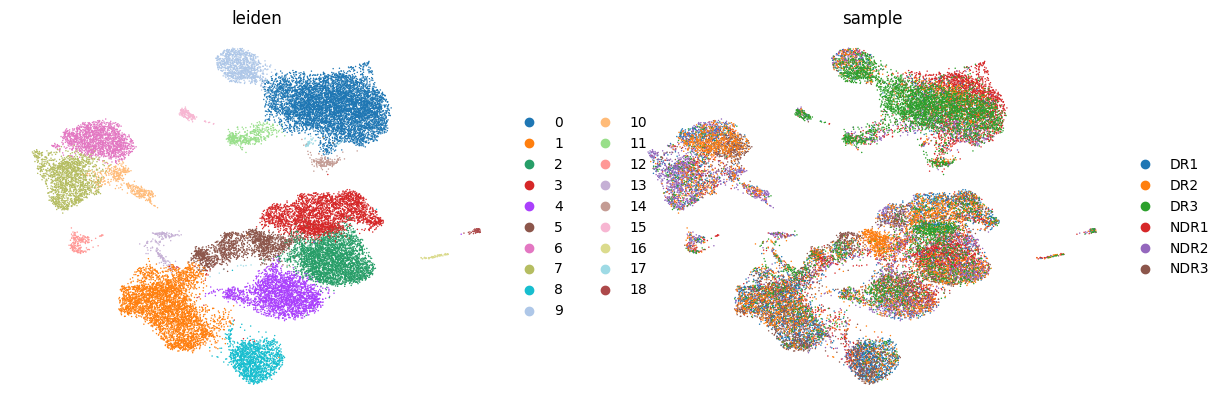

In [201]:
#plot umap, one with clusters labeled, one with samples labelled 
sc.pl.umap(adata, color = ['leiden', 'sample'], frameon = False, save = "label_samplesandleiden.png")
#samples were well integrated, distinct clusters seen in leiden 

# Step 4: Find markers/cell types. 

In [18]:
#find markers for clusters 
sc.tl.rank_genes_groups(adata, 'leiden')

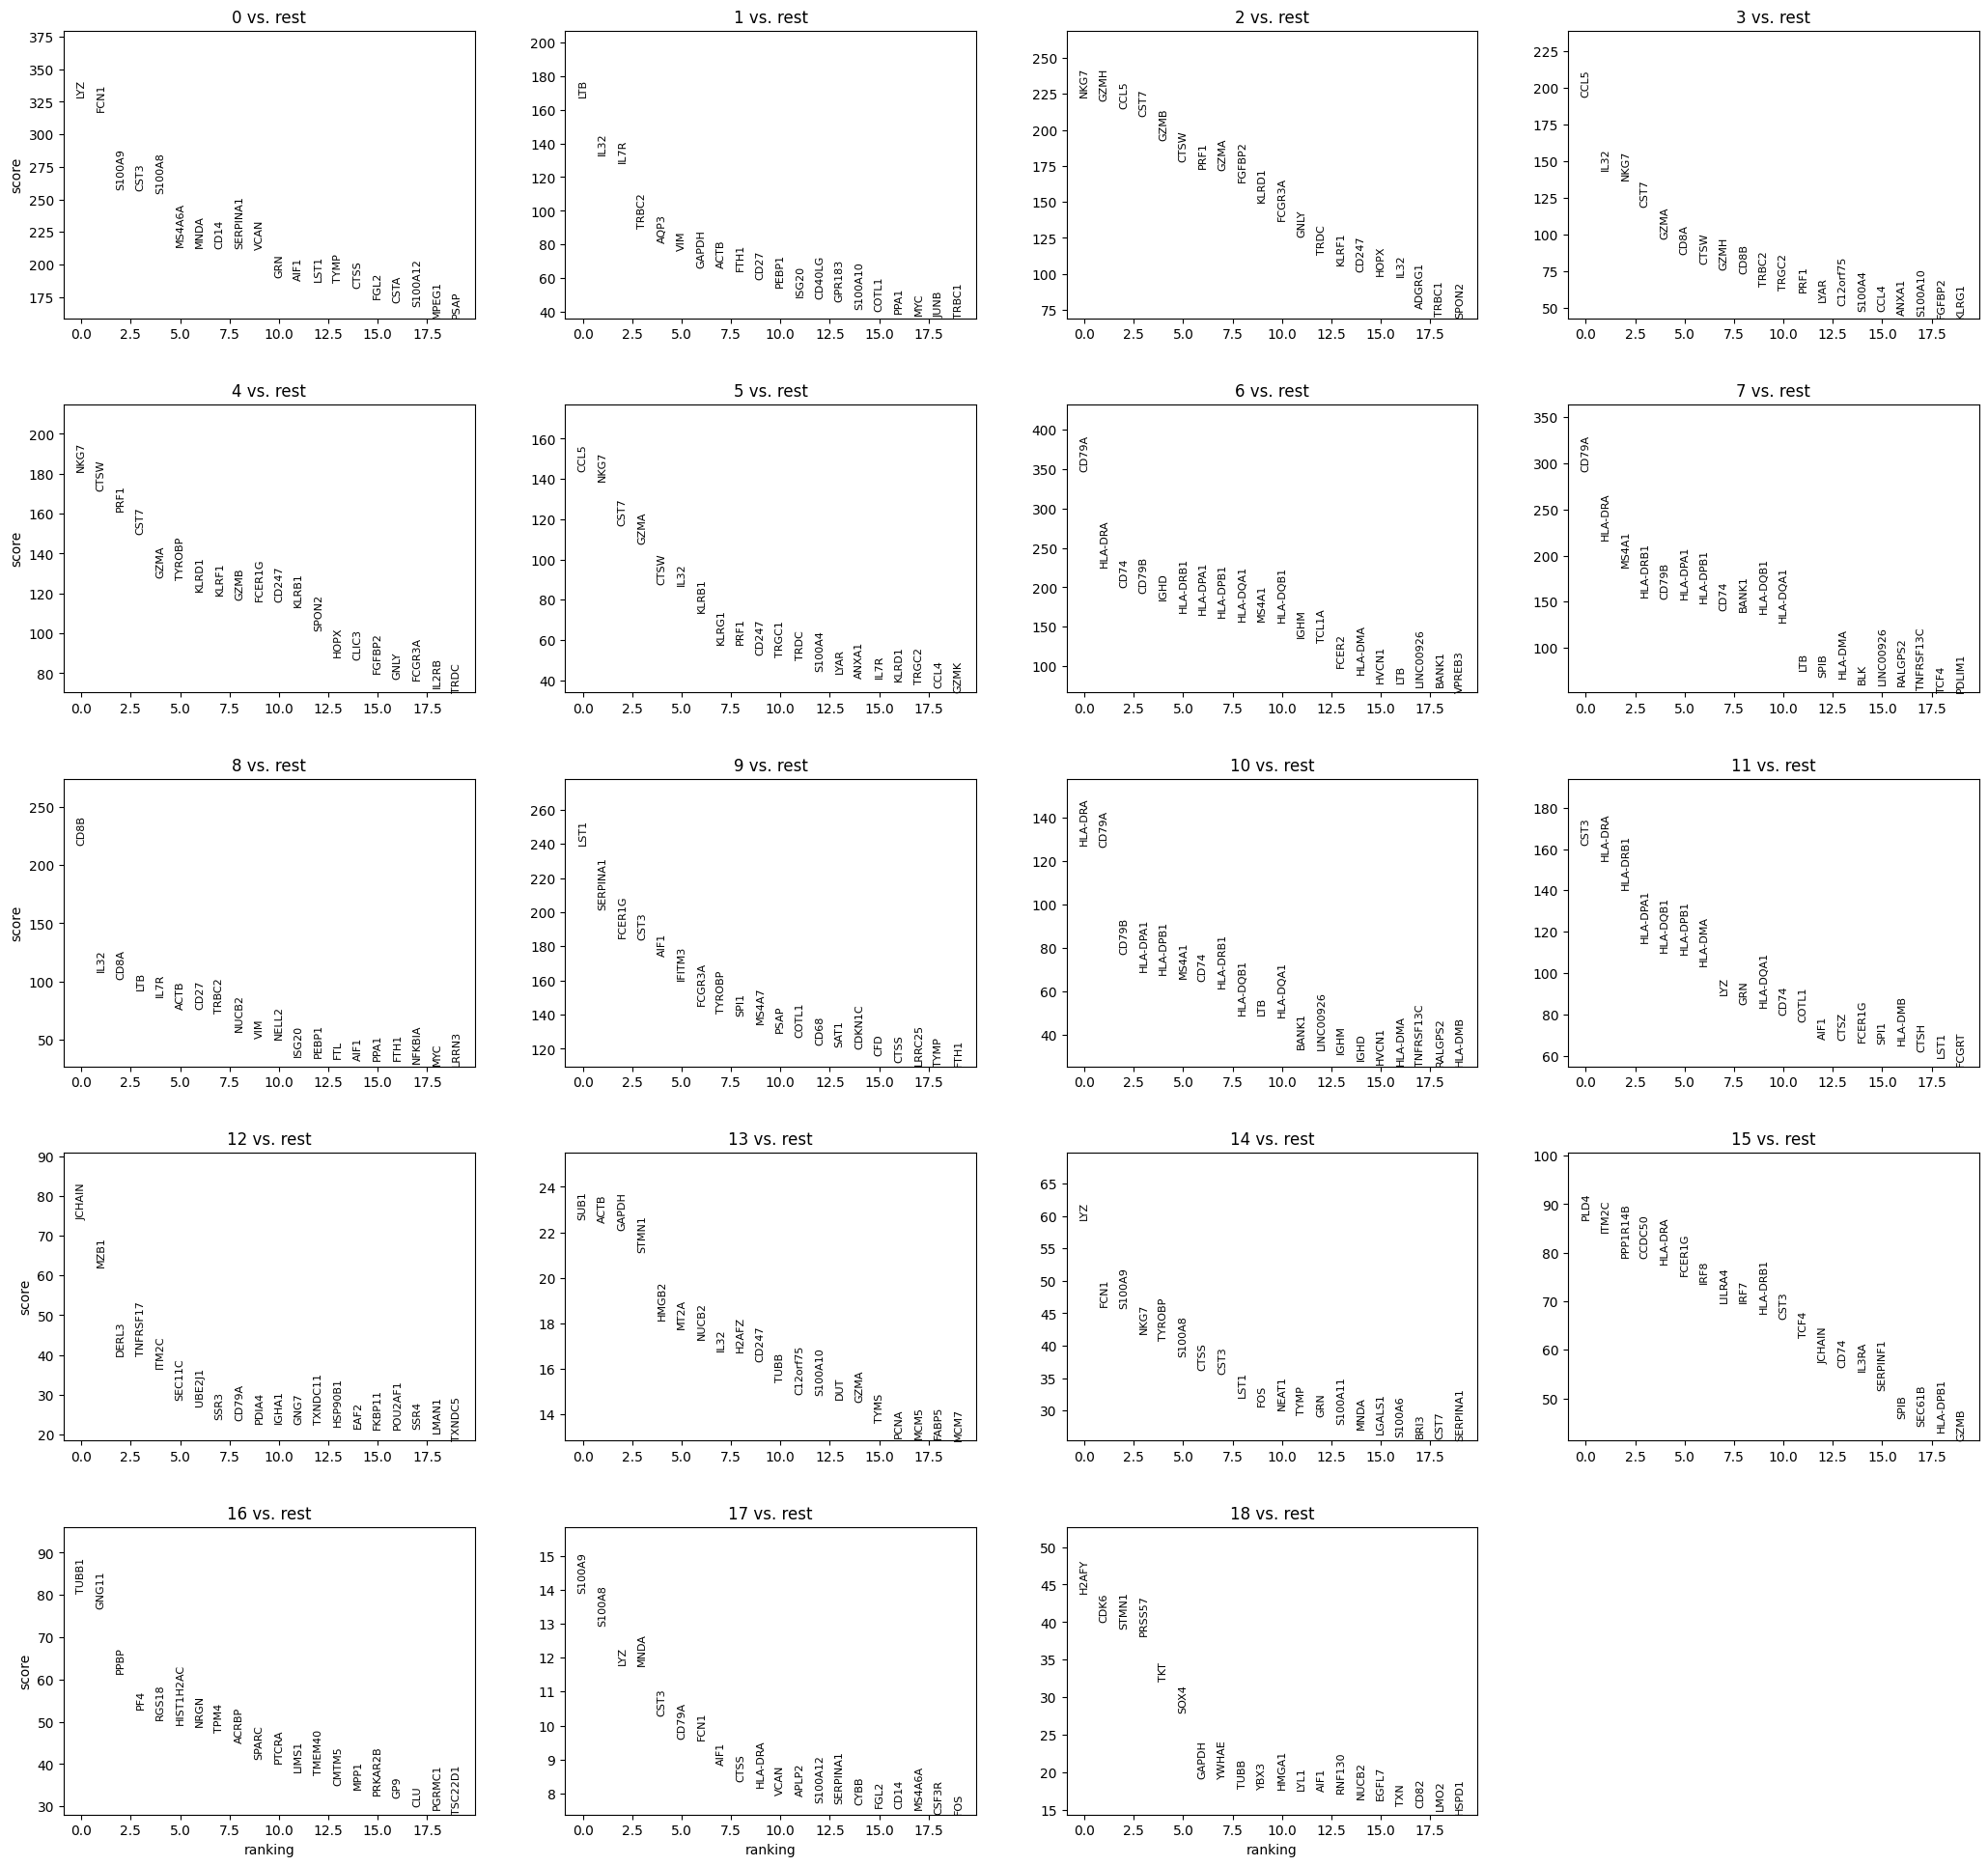

In [200]:
sc.pl.rank_genes_groups(adata, n_genes = 20, sharey = False, save = "top20genespercluster.png")
#show top 20 genes for each cluster 
#higher and on left is most significant in each cluster 

In [21]:
markers = sc.get.rank_genes_groups_df(adata, None) #get markers for anndata
#save as df 
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
#only want those with padj < 0.05 and lfc > .5
markers


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


group     names      scores  logfoldchanges     pvals  pvals_adj
0         0       LYZ  328.676544        7.205810  0.000000   0.000000
1         0      FCN1  317.634125        6.803956  0.000000   0.000000
2         0    S100A9  257.915741        6.633847  0.000000   0.000000
3         0      CST3  256.664307        6.091304  0.000000   0.000000
4         0    S100A8  254.342590        6.793543  0.000000   0.000000
...     ...       ...         ...             ...       ...        ...
16070    18      MND1    2.254842        5.340172  0.028071   0.038094
16071    18      CD74    2.244179        0.510180  0.028758   0.038965
16072    18      DCPS    2.186278        1.099668  0.032977   0.044613
16073    18     SPCS3    2.173845        0.900894  0.033944   0.045710
16074    18  TNFSF13B    2.134133        1.026184  0.037212   0.049957

[4206 rows x 6 columns]

In [23]:
markers_scvi = model.differential_expression(groupby = 'leiden')
markers_scvi #use scvi model to calc marker genes 

DE...:   0%|          | 0/19 [00:00<?, ?it/s]

DE...: 100%|██████████| 19/19 [00:33<00:00,  1.78s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
SERPINA1    0.9976        0.0024      6.029880  0.003846  0.000588   
ASGR1       0.9974        0.0026      5.949637  0.000790  0.000044   
S100A9      0.9974        0.0026      5.949637  0.076350  0.004096   
CYP1B1      0.9972        0.0028      5.875328  0.000548  0.000028   
CD14        0.9970        0.0030      5.806135  0.003862  0.000144   
...            ...           ...           ...       ...       ...   
DDOST       0.7368        0.2632      1.029402  0.001192  0.000778   
SEC61A1     0.7366        0.2634      1.028371  0.000429  0.000376   
DCPS        0.7238        0.2762      0.963390  0.000410  0.000281   
TXNDC11     0.7046        0.2954      0.869300  0.000180  0.000168   
PEA15       0.6688        0.3312      0.702763  0.000226  0.000236   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
SERPINA1           0.0   0.25  4.716050    5.017012  1.780875  ...   
ASGR1              0.0   0.25  5.111002    5.377663  1.488821  ...   
S100A9             0.0   0.25  4.831372    5.036972  1.695798  ...   
CYP1B1             0.0   0.25  5.315014    5.559449  2.029996  ...   
CD14               0.0   0.25  5.743193    6.017154  1.640831  ...   
...                ...    ...       ...         ...       ...  ...   
DDOST              0.0   0.25  0.886938    0.530567  1.026303  ...   
SEC61A1            0.0   0.25  0.315730    0.285720  0.706224  ...   
DCPS               0.0   0.25  0.748600    0.483125  0.905271  ...   
TXNDC11            0.0   0.25  0.176799    0.185592  0.626202  ...   
PEA15              0.0   0.25  0.057012    0.057615  0.781923  ...   

           raw_mean1  raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
SERPINA1    6.284550   1.115658               0.959230               0.115798   
ASGR1       1.373935   0.054185               0.674005               0.037615   
S100A9    155.570679   4.196133               0.999674               0.538520   
CYP1B1      0.733527   0.018998               0.361872               0.013475   
CD14        6.618860   0.126893               0.932159               0.054566   
...              ...        ...                    ...                    ...   
DDOST       1.421053   0.511979               0.701754               0.364553   
SEC61A1     0.298246   0.272947               0.263158               0.217860   
DCPS        0.315789   0.206256               0.315789               0.171105   
TXNDC11     0.105263   0.157068               0.105263               0.123463   
PEA15       0.140351   0.209250               0.122807               0.153525   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
SERPINA1             38.503250              6.302020            True   
ASGR1                 8.537582              0.391676            True   
S100A9              887.450439             41.530323            True   
CYP1B1                5.101347              0.187013            True   
CD14                 39.396809              1.166320            True   
...                        ...                   ...             ...   
DDOST                16.927717              8.125694           False   
SEC61A1               3.616747              3.765841           False   
DCPS                  3.975140              3.106555           False   
TXNDC11               1.378642              1.978055           False   
PEA15                 1.487781              2.044811           False   

          comparison  group1 group2  
SERPINA1   0 vs Rest       0   Rest  
ASGR1      0 vs Rest       0   Rest  
S100A9     0 vs Rest       0   Rest  
CYP1B1     0 vs Rest       0   Rest  
CD14       0 vs Rest       0   Rest  
...              ...     ...    ...  
DDOST     18 vs Rest      18   Rest  
SEC61A1   18 vs Rest      18   Rest  
DCPS      18 vs Rest      18   Rest  
TXNDC11   18 vs Rest      18   Rest  
PEA15     18 vs Rest      18   Rest  

[16682 rows x 22 columns]

In [24]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean>.5)] #needs to be de and have lfc > .5
markers_scvi

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
SERPINA1    0.9976        0.0024      6.029880  0.003846  0.000588   
ASGR1       0.9974        0.0026      5.949637  0.000790  0.000044   
S100A9      0.9974        0.0026      5.949637  0.076350  0.004096   
CYP1B1      0.9972        0.0028      5.875328  0.000548  0.000028   
CD14        0.9970        0.0030      5.806135  0.003862  0.000144   
...            ...           ...           ...       ...       ...   
FCGRT       0.8962        0.1038      2.155698  0.001501  0.000980   
IFI44L      0.8958        0.1042      2.151405  0.000858  0.000508   
CCNB1       0.8956        0.1044      2.149264  0.000077  0.000037   
C1orf21     0.8954        0.1046      2.147127  0.001198  0.000561   
CPNE5       0.8944        0.1056      2.136495  0.000124  0.000189   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
SERPINA1           0.0   0.25  4.716050    5.017012  1.780875  ...   
ASGR1              0.0   0.25  5.111002    5.377663  1.488821  ...   
S100A9             0.0   0.25  4.831372    5.036972  1.695798  ...   
CYP1B1             0.0   0.25  5.315014    5.559449  2.029996  ...   
CD14               0.0   0.25  5.743193    6.017154  1.640831  ...   
...                ...    ...       ...         ...       ...  ...   
FCGRT              0.0   0.25  1.133137    1.240138  1.379941  ...   
IFI44L             0.0   0.25  1.200222    1.187020  1.476691  ...   
CCNB1              0.0   0.25  1.396237    1.224281  1.360878  ...   
C1orf21            0.0   0.25  2.369738    2.460328  2.301327  ...   
CPNE5              0.0   0.25  0.647710    0.907605  1.809527  ...   

           raw_mean1  raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
SERPINA1    6.284550   1.115658               0.959230               0.115798   
ASGR1       1.373935   0.054185               0.674005               0.037615   
S100A9    155.570679   4.196133               0.999674               0.538520   
CYP1B1      0.733527   0.018998               0.361872               0.013475   
CD14        6.618860   0.126893               0.932159               0.054566   
...              ...        ...                    ...                    ...   
FCGRT       1.000000   1.194731               0.666667               0.373010   
IFI44L      0.263158   0.190749               0.105263               0.120139   
CCNB1       0.087719   0.014219               0.087719               0.011892   
C1orf21     0.842105   0.232181               0.684211               0.169332   
CPNE5       0.000000   0.112791               0.000000               0.067622   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
SERPINA1             38.503250              6.302020            True   
ASGR1                 8.537582              0.391676            True   
S100A9              887.450439             41.530323            True   
CYP1B1                5.101347              0.187013            True   
CD14                 39.396809              1.166320            True   
...                        ...                   ...             ...   
FCGRT                12.860190              9.391730            True   
IFI44L                2.525903              3.029629            True   
CCNB1                 0.916804              0.227799            True   
C1orf21              11.191878              4.690486            True   
CPNE5                 0.000000              1.433496            True   

          comparison  group1 group2  
SERPINA1   0 vs Rest       0   Rest  
ASGR1      0 vs Rest       0   Rest  
S100A9     0 vs Rest       0   Rest  
CYP1B1     0 vs Rest       0   Rest  
CD14       0 vs Rest       0   Rest  
...              ...     ...    ...  
FCGRT     18 vs Rest      18   Rest  
IFI44L    18 vs Rest      18   Rest  
CCNB1     18 vs Rest      18   Rest  
C1orf21   18 vs Rest      18   Rest  
CPNE5     18 vs Rest      18   Rest  

[3765 rows x 22 columns]

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


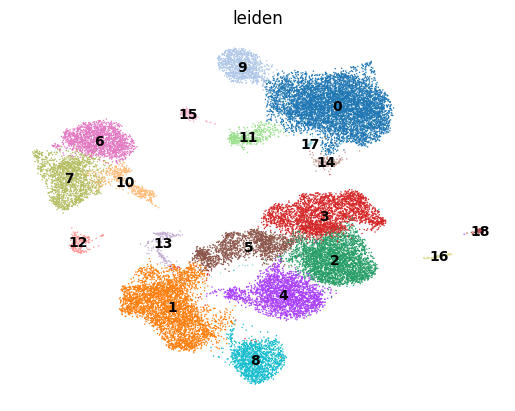

In [199]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data", save = "unlabelled.png")

In [74]:
#for markers, going to use a dictionary 
for x in range(0,19): 
    print(f'"{x}":"", ')

"0":"", 
"1":"", 
"2":"", 
"3":"", 
"4":"", 
"5":"", 
"6":"", 
"7":"", 
"8":"", 
"9":"", 
"10":"", 
"11":"", 
"12":"", 
"13":"", 
"14":"", 
"15":"", 
"16":"", 
"17":"", 
"18":"", 


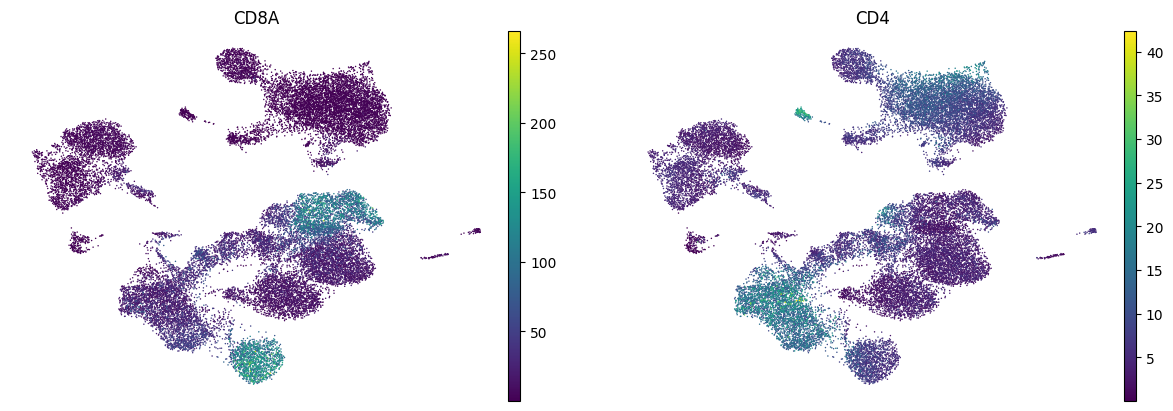

In [28]:
#start with markers that u expect to see, expect to see blood cells common for most all data 
sc.pl.umap(adata, color = ['CD8A', 'CD4'], frameon = False, layer = 'scvi_normalized')
#CD4 and CD8A markers seem to be clustered apart well 

In [31]:
markers[markers.names == 'CD8A']

group names      scores  logfoldchanges  pvals  pvals_adj
2639     3  CD8A   86.843956        5.595390    0.0        0.0
7026     8  CD8A  101.766777        6.342653    0.0        0.0

In [32]:
markers[markers.names == 'CD4']

group names     scores  logfoldchanges          pvals      pvals_adj
149       0   CD4  62.046509        2.659285   0.000000e+00   0.000000e+00
910       1   CD4  26.719374        1.867356  8.684082e-146  2.147781e-145
8103      9   CD4  19.055986        1.602051   6.105211e-70   1.425632e-69
9775     11   CD4  17.786509        1.959254   2.963856e-53   1.146373e-52
12497    14   CD4   6.830368        1.392815   1.216131e-10   3.149742e-10
13257    15   CD4  12.847989        2.932001   5.773979e-26   1.830164e-25

In [ ]:
#Now use PanglaoDB and past reference single cell annotation markers for peripheral blood mononuclear cells 

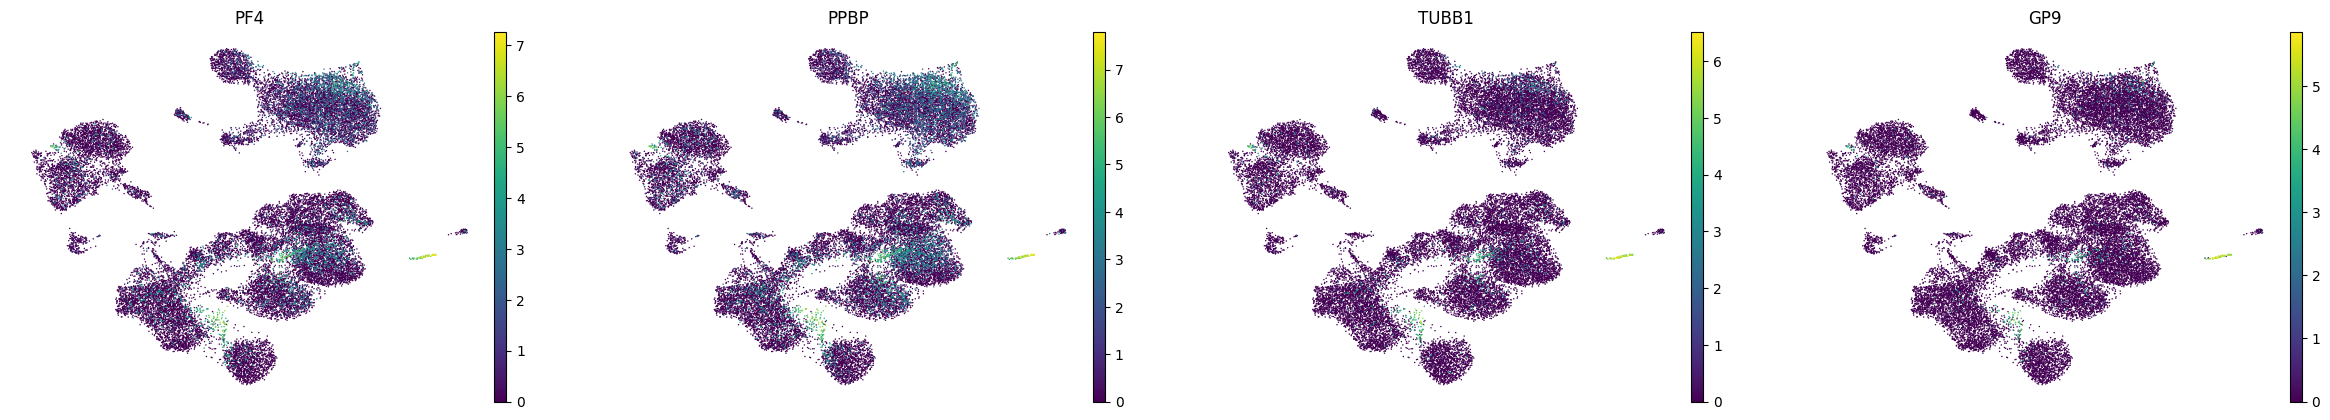

group names     scores  logfoldchanges         pvals     pvals_adj
344       0   PF4  16.588058        1.034555  5.908621e-61  8.646282e-61
1865      2   PF4   8.085306        0.759112  8.368939e-16  1.188985e-15
14051    16   PF4  52.950699        9.646609  5.463707e-53  2.076682e-52

In [42]:
#for Platelets: PF4, GP9
sc.pl.umap(adata, color = ['PF4', 'GP9'], frameon = False) 
markers[markers.names == 'PF4']
markers[markers.names == 'GP9']
#cluster 16

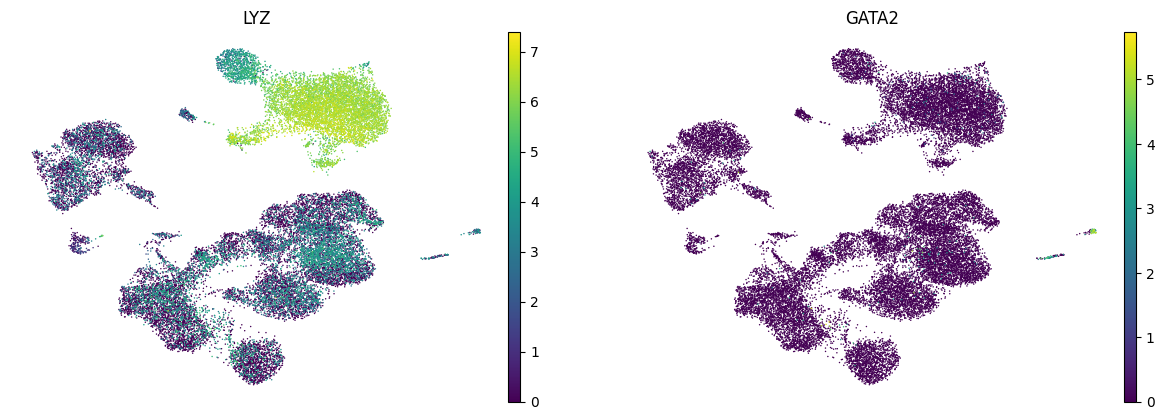

group  names     scores  logfoldchanges         pvals     pvals_adj
14140    16  GATA2   6.285842        6.570533  3.844685e-08  5.217363e-08
15827    18  GATA2  12.907934        9.756315  2.010654e-18  8.446671e-18

In [75]:
#for Basophils: LYZ, GATA2
sc.pl.umap(adata, color = ['LYZ', 'GATA2'], frameon = False) 
markers[markers.names == 'LYZ']
markers[markers.names == 'GATA2']
#cluster 18

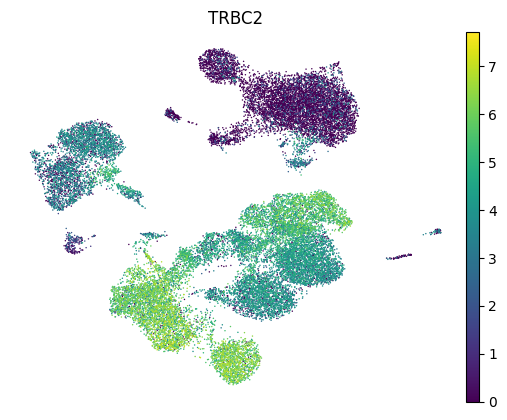

group  names     scores  logfoldchanges          pvals      pvals_adj
881       1  TRBC2  89.871361        3.901683   0.000000e+00   0.000000e+00
1822      2  TRBC2  20.969568        0.953442   4.513237e-94   9.641417e-94
2643      3  TRBC2  65.309212        2.964349   0.000000e+00   0.000000e+00
4415      5  TRBC2  26.576065        1.624476  2.390991e-134  9.247974e-134
7031      8  TRBC2  72.552734        4.085110   0.000000e+00   0.000000e+00
8829     10  TRBC2  14.709723        1.554217   1.492419e-40   7.361482e-40
11459    13  TRBC2   9.389625        1.976450   1.735687e-17   5.079778e-17

In [55]:
#for T cells: TRBC2, 
sc.pl.umap(adata, color = ['TRBC2'], frameon = False) 
markers[markers.names == 'TRBC2']
#cluster 8 

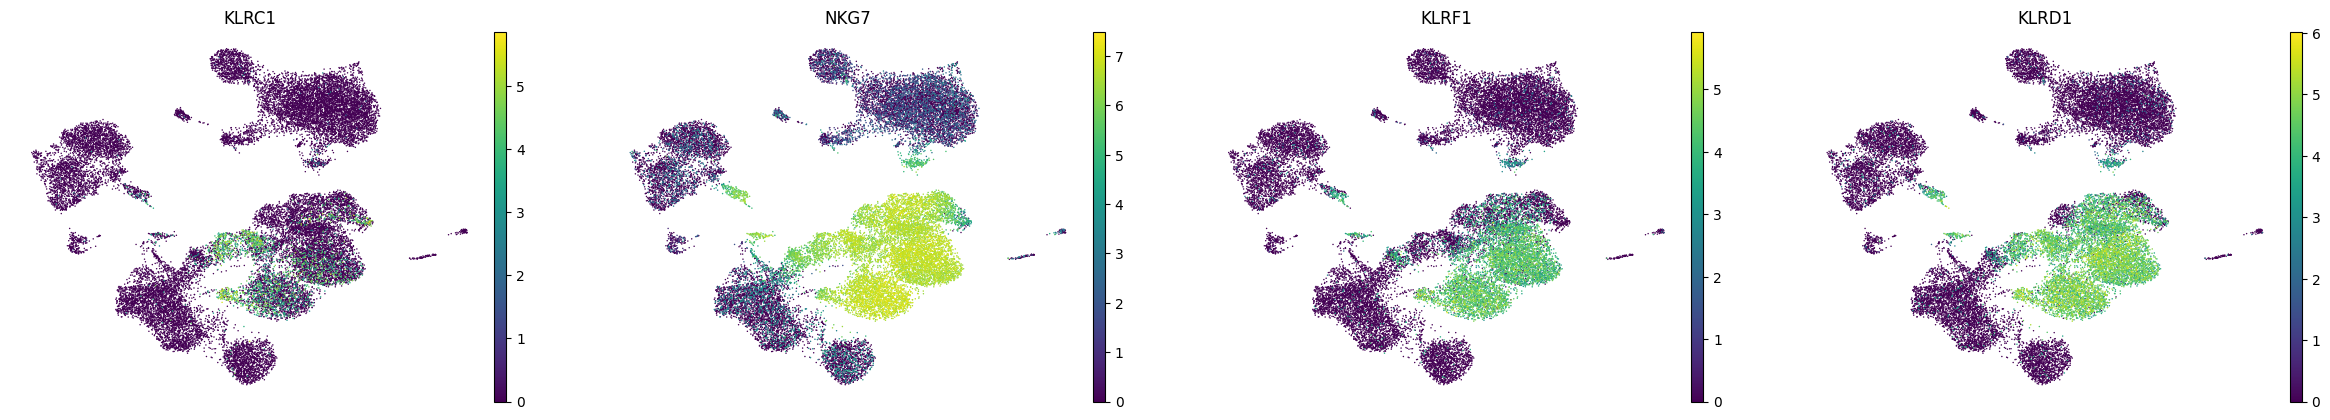

group  names      scores  logfoldchanges          pvals      pvals_adj
1765      2  KLRD1  150.162155        5.225063   0.000000e+00   0.000000e+00
2656      3  KLRD1   35.571762        2.381901  6.404323e-237  2.392764e-236
3518      4  KLRD1  120.955841        4.999948   0.000000e+00   0.000000e+00
4406      5  KLRD1   39.593430        3.109328  3.024388e-248  2.392264e-247
12375    14  KLRD1   11.684808        1.937543   5.254873e-24   2.651597e-23

In [60]:
#for NK cells: KLRC1, KLRF1, NKG7, and KLRD1
sc.pl.umap(adata, color = ['KLRC1', 'NKG7', 'KLRF1','KLRD1'], frameon = False) 
markers[markers.names == 'KLRC1']
markers[markers.names == 'NKG7']
markers[markers.names == 'KLRF1']
markers[markers.names == 'KLRD1']
#4 and 5,2,3, 

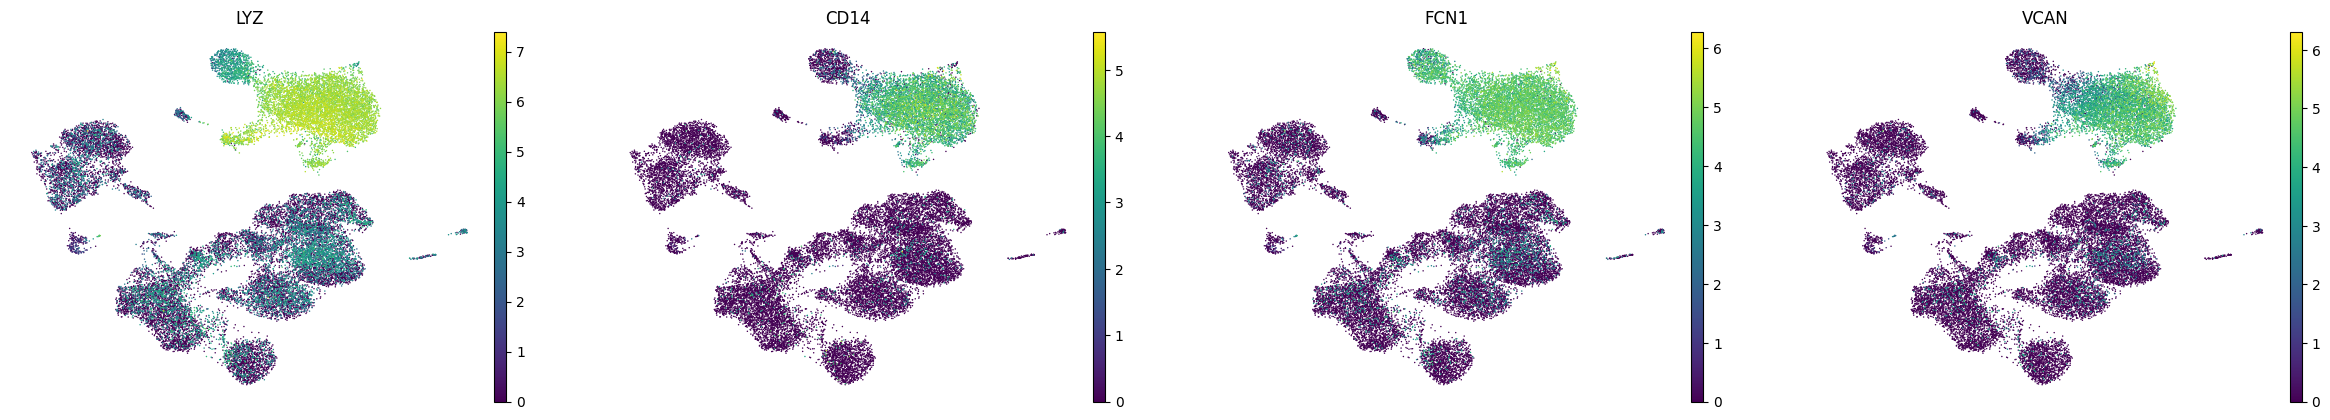

group names      scores  logfoldchanges          pvals      pvals_adj
1         0  FCN1  317.634125        6.803956   0.000000e+00   0.000000e+00
7942      9  FCN1   59.421436        3.862898   0.000000e+00   0.000000e+00
9858     11  FCN1   10.200800        1.540025   5.606404e-22   1.333990e-21
12293    14  FCN1   46.009087        4.349382  6.328124e-107  2.645759e-105
14932    17  FCN1    9.591917        3.169646   1.113569e-13   7.136593e-13

In [87]:
#for classical monocytes: LYZ, CD14, FCN1, and VCAN
sc.pl.umap(adata, color = ['LYZ', 'CD14', 'FCN1','VCAN'], frameon = False)
markers[markers.names == 'CD14']
markers[markers.names == 'FCN1']
markers[markers.names == 'LYZ']
markers[markers.names == 'VCAN']
#0, 11, 14, 17, 

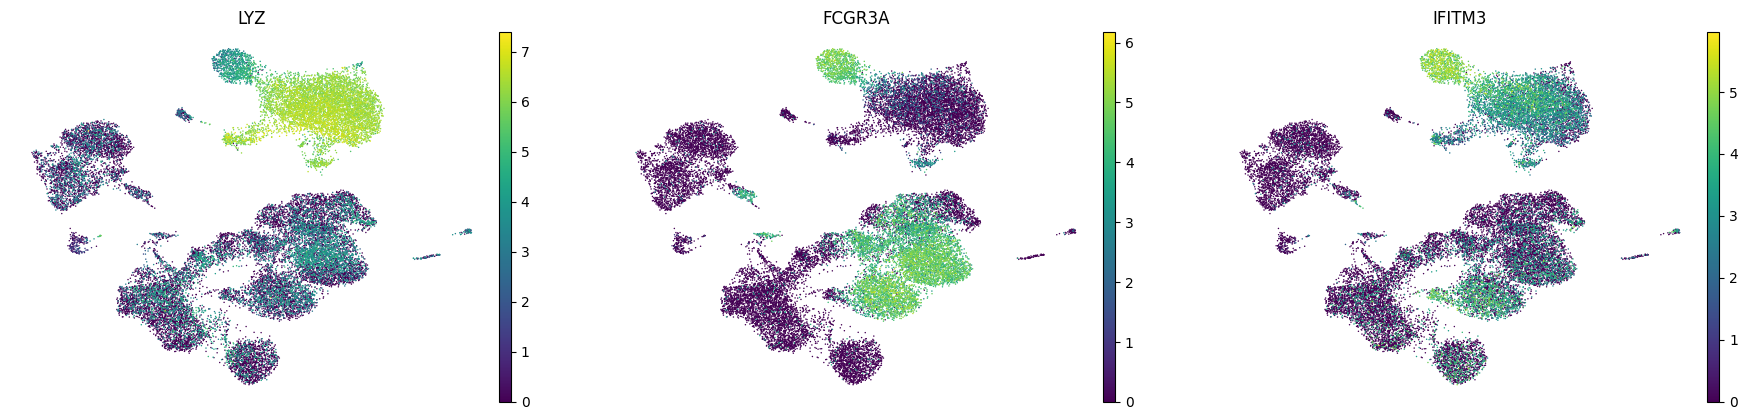

group   names      scores  logfoldchanges         pvals     pvals_adj
1766      2  FCGR3A  136.834930        5.022107  0.000000e+00  0.000000e+00
2717      3  FCGR3A    9.113259        0.642377  1.307961e-19  2.014720e-19
3529      4  FCGR3A   76.458435        4.270511  0.000000e+00  0.000000e+00
4461      5  FCGR3A   11.429841        1.051516  2.995262e-29  5.909753e-29
7908      9  FCGR3A  145.491943        5.063061  0.000000e+00  0.000000e+00
12476    14  FCGR3A    7.542448        1.316784  2.001943e-12  5.633672e-12

In [88]:
#for non-classical monocytes: LYZ, FCGR3A, and IFITM3
sc.pl.umap(adata, color = ['LYZ', 'FCGR3A', 'IFITM3'], frameon = False)
markers[markers.names == 'FCGR3A']
markers[markers.names == 'LYZ']
markers[markers.names == 'IFITM3']
# 9

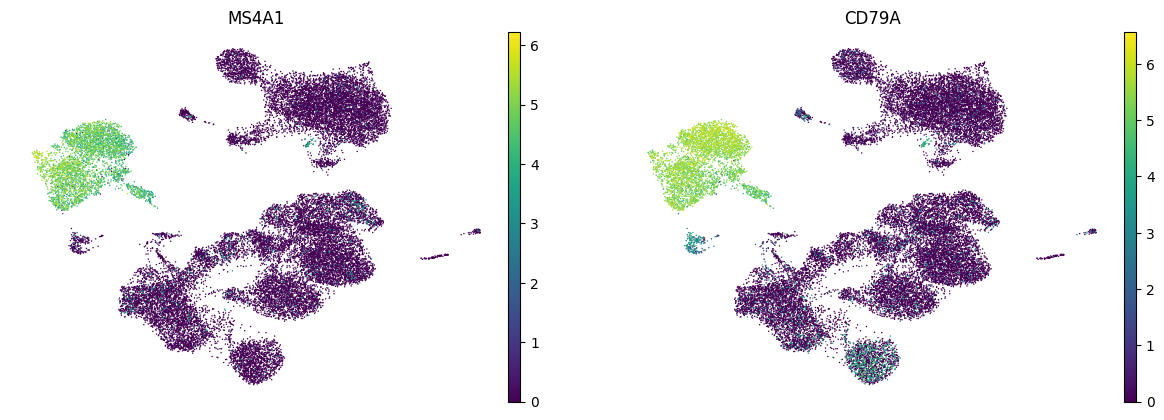

group  names      scores  logfoldchanges         pvals     pvals_adj
5268      6  CD79A  347.463135        8.195850  0.000000e+00  0.000000e+00
6146      7  CD79A  291.683105        7.793029  0.000000e+00  0.000000e+00
7104      8  CD79A    5.142925        0.575873  3.029314e-07  4.195170e-07
8781     10  CD79A  126.153000        6.664590  0.000000e+00  0.000000e+00
10544    12  CD79A   23.486912        3.245869  1.234984e-61  4.480644e-61
14931    17  CD79A    9.608968        3.680047  1.058308e-13  6.832315e-13

In [73]:
#for B cells MS4A1 and CD79A
sc.pl.umap(adata, color = ['MS4A1', 'CD79A'], frameon = False)
markers[markers.names == 'MS4A1']
markers[markers.names == 'CD79A']
#6, 7, 10

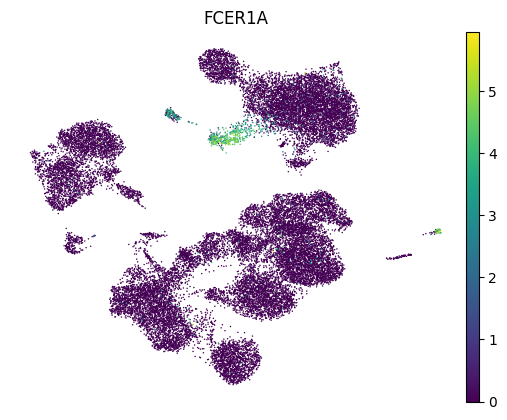

group   names     scores  logfoldchanges          pvals      pvals_adj
9679     11  FCER1A  52.536163        9.586894  6.835595e-183  1.052922e-181
13262    15  FCER1A  12.250575        5.647608   2.568434e-24   7.670356e-24
15849    18  FCER1A  10.085838        7.438937   3.339779e-14   1.159022e-13

In [78]:
#for conventional type 2 dendritic cells:  FCER1A
sc.pl.umap(adata, color = ['FCER1A'], frameon = False)
markers[markers.names == 'FCER1A']
#11

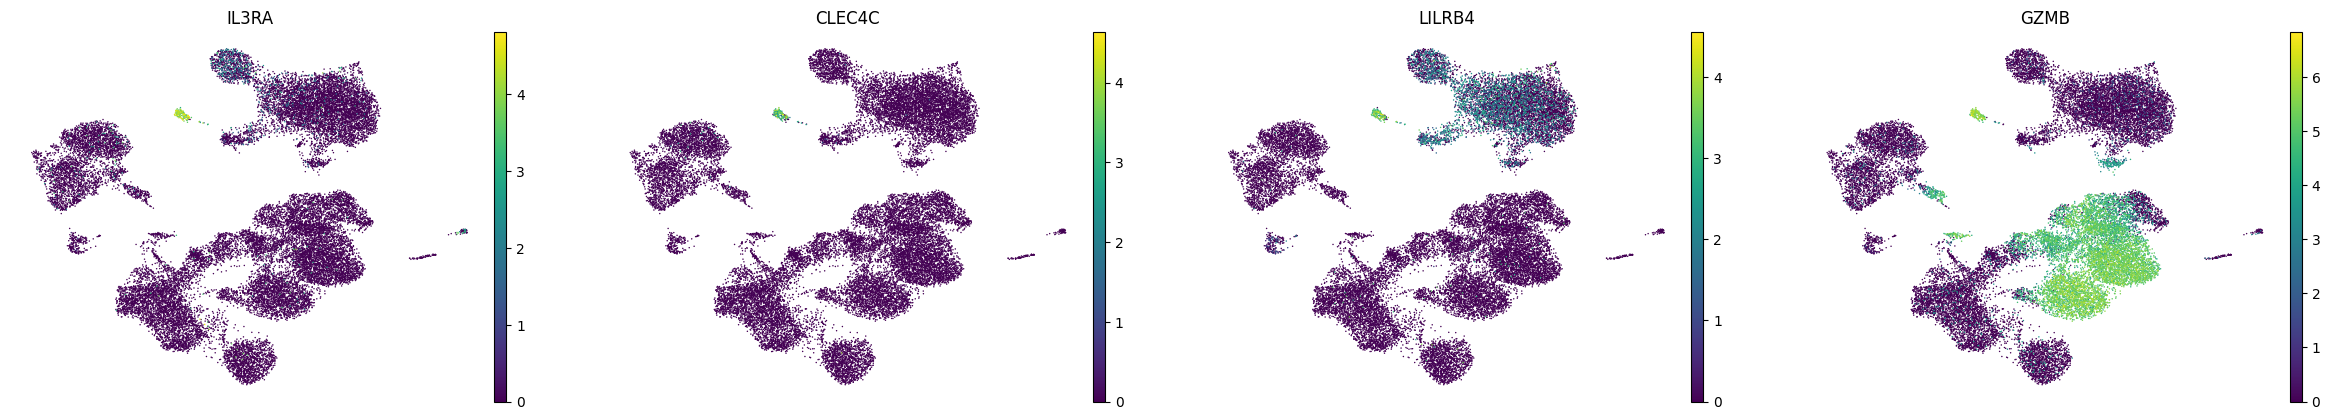

group names      scores  logfoldchanges          pvals      pvals_adj
1760      2  GZMB  193.103577        5.854845   0.000000e+00   0.000000e+00
2654      3  GZMB   40.147713        2.792132  5.636566e-291  2.486887e-290
3520      4  GZMB  116.681366        5.454278   0.000000e+00   0.000000e+00
4421      5  GZMB   21.550735        1.995320   6.893826e-92   2.116356e-91
11611    13  GZMB    3.040530        0.903884   2.692372e-03   3.999835e-03
12349    14  GZMB   14.595871        2.206702   9.124794e-33   6.513471e-32
13189    15  GZMB   41.304028        5.585053   4.627879e-86   5.888808e-85

In [83]:
#for plasmacytoid dendritic cells IL3RA, CLEC4C, LILRB4, and GZMB)
sc.pl.umap(adata, color = ['IL3RA', 'CLEC4C', 'LILRB4', 'GZMB'], frameon = False)
markers[markers.names == 'IL3RA']
markers[markers.names == 'CLEC4C']
markers[markers.names == 'LILRB4']
markers[markers.names == 'GZMB']
#15


In [92]:
#unsure about 12 
markers_scvi[markers_scvi.group1 == '12']
markers[markers.group == '12']
#B-cells for 12 

group     names     scores  logfoldchanges          pvals      pvals_adj
10536    12    JCHAIN  74.151039        8.858279  5.389526e-154  1.028697e-152
10537    12      MZB1  62.131706        7.439188  1.476159e-137  2.234599e-136
10538    12     DERL3  39.901474        6.779149  9.030424e-100   7.410011e-99
10539    12  TNFRSF17  39.756836        7.884735   2.715058e-99   2.186991e-98
10540    12     ITM2C  36.732147        4.795160   4.248997e-94   3.057884e-93
...     ...       ...        ...             ...            ...            ...
10741    12   CTNNAL1   2.121492        1.383451   3.504309e-02   3.970042e-02
10742    12     CDCA3   2.073943        2.770191   3.931066e-02   4.442054e-02
10743    12      TPX2   2.073219        1.942328   3.937463e-02   4.443563e-02
10744    12     HELLS   2.065724        0.704493   4.006400e-02   4.515558e-02
10745    12      DHFR   2.027513        0.595482   4.385176e-02   4.923510e-02

[203 rows x 6 columns]

In [94]:
#unsure about 13
markers_scvi[markers_scvi.group1 == '13']
#Erythroid like Cells for 13 

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
CDKN3       0.9918        0.0082      4.795386  0.000581  0.000027   
MND1        0.9906        0.0094      4.657600  0.000258  0.000010   
CDCA7       0.9898        0.0102      4.575114  0.000610  0.000078   
PTTG1       0.9876        0.0124      4.377580  0.001589  0.000150   
CCNB2       0.9862        0.0138      4.269190  0.000356  0.000008   
...            ...           ...           ...       ...       ...   
CDCA8       0.9310        0.0690      2.602153  0.000160  0.000019   
H2AFZ       0.9308        0.0692      2.599043  0.007044  0.002377   
TNFRSF18    0.9304        0.0696      2.592850  0.000299  0.000229   
TNFRSF4     0.9302        0.0698      2.589765  0.000209  0.000269   
GP9         0.9302        0.0698      2.589765  0.000097  0.000127   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
CDKN3              0.0   0.25  4.156884    4.106108  1.955520  ...   0.757895   
MND1               0.0   0.25  4.557477    4.527616  2.211449  ...   0.278947   
CDCA7              0.0   0.25  3.530104    3.335803  1.918959  ...   0.552631   
PTTG1              0.0   0.25  3.495394    3.448481  1.717262  ...   2.047368   
CCNB2              0.0   0.25  4.933325    4.990219  2.573928  ...   0.594737   
...                ...    ...       ...         ...       ...  ...        ...   
CDCA8              0.0   0.25  2.307676    2.360323  2.200378  ...   0.247368   
H2AFZ              0.0   0.25  1.707062    1.674463  1.157798  ...   8.631581   
TNFRSF18           0.0   0.25  1.644061    1.385188  3.050358  ...   0.152632   
TNFRSF4            0.0   0.25  1.078204    1.235877  2.380262  ...   0.052632   
GP9                0.0   0.25  1.040572    1.134281  2.395454  ...   0.021053   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
CDKN3      0.009093               0.305263               0.008239   
MND1       0.001744               0.168421               0.001559   
CDCA7      0.019039               0.326316               0.016442   
PTTG1      0.080537               0.500000               0.069255   
CCNB2      0.003155               0.178947               0.002598   
...             ...                    ...                    ...   
CDCA8      0.005233               0.173684               0.004973   
H2AFZ      1.383326               0.926316               0.691471   
TNFRSF18   0.081168               0.089474               0.057452   
TNFRSF4    0.079312               0.026316               0.053704   
GP9        0.062611               0.015789               0.024644   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
CDKN3                 5.846922              0.160096            True   
MND1                  2.073075              0.018301            True   
CDCA7                 5.326303              0.355068            True   
PTTG1                16.386658              1.433577            True   
CCNB2                 4.210510              0.026971            True   
...                        ...                   ...             ...   
CDCA8                 1.963822              0.085177            True   
H2AFZ                77.131538             24.146894            True   
TNFRSF18              1.597463              1.684971            True   
TNFRSF4               0.234017              1.963891            True   
GP9                   0.251251              0.836405            True   

          comparison  group1 group2  
CDKN3     13 vs Rest      13   Rest  
MND1      13 vs Rest      13   Rest  
CDCA7     13 vs Rest      13   Rest  
PTTG1     13 vs Rest      13   Rest  
CCNB2     13 vs Rest      13   Rest  
...              ...     ...    ...  
CDCA8     13 vs Rest      13   Rest  
H2AFZ     13 vs Rest      13   Rest  
TNFRSF18  13 vs Rest      13   Rest  
TNFRSF4   13 vs Rest      13   Rest  
GP9       13 vs Rest      13   Rest  

[157 rows x 22 columns]

In [99]:
cell_types = {"0":"Classical Monocytes", 
"1":"T Cells", 
"2":"NK Cells", 
"3":"NK Cells", 
"4":"NK Cells", 
"5":"NK Cells", 
"6":"B Cells", 
"7":"B Cells", 
"8":"T Cells", 
"9":"Nonclassical Monocytes", 
"10":"B Cells", 
"11":"Conventional Type II Dendritic Cells", 
"12":"B Cells", 
"13":"Erythroid like Cells", 
"14":"Classical Monocytes", 
"15":"Plasmacytoid Dendritic Cells", 
"16":"Platelets", 
"17":"Classical Monocytes", 
"18":"Basophiles"} 

In [100]:
adata.obs['cell_type'] = adata.obs.leiden.map(cell_types)

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


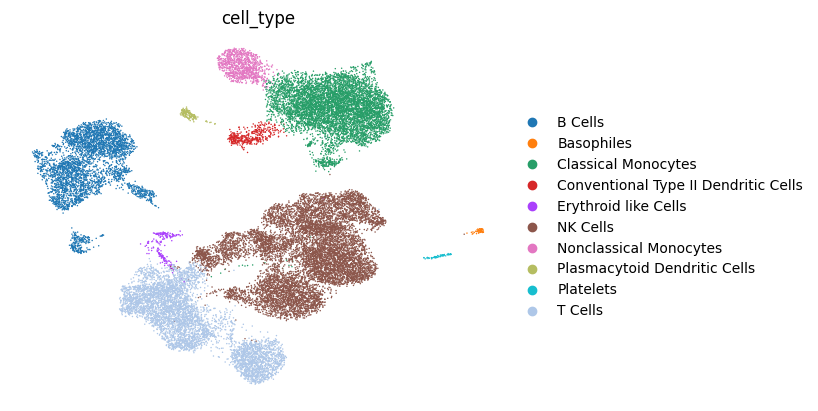

In [198]:
sc.pl.umap(adata, color = ['cell_type'], frameon = False, save = 'LabelledCellTypes.png')

In [ ]:
#save data 
adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers 
adata.write_h5ad('readyforanalysis.h5ad')
model.save('final.model')

# Step 5: Analysis and Plot Figures

In [2]:
adata = sc.read_h5ad('readyforanalysis.h5ad')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
model  = scvi.model.SCVI.load('final.model', adata)

INFO     File final.model/model.pt already downloaded                                                              


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [103]:
marker_gene_dict = {
    "Classical Monocytes": ['CD14', 'FCN1', 'VCAN'], 
    "B Cells": ['MS4A1', 'CD79A', 'JCHAIN'], 
    "Basophiles": ['GATA2'], 
    "Conventional Type II Dendritic Cells": ['FCER1A'], 
    "Erythroid like Cells": ['CDKN3'], 
    "NK Cells": ['KLRC1', 'KLRF1', 'NKG7', 'KLRD1'], 
    "Nonclassical Monocytes": ['FCGR3A', 'IFITM3'], 
    "Plasmacytoid Dendritic Cells" : ['IL3RA', 'CLEC4C', 'LILRB4', 'GZMB'], 
    "Platelets": ['PF4', 'GP9'], 
    "T cells": ['TRBC2']
    
}

In [104]:
adata.obs

sample  _scvi_batch  _scvi_labels  doublet  n_genes  \
AAACCCAGTCGAACGA-1   NDR1            0             0    False      251   
AAACCCAGTGACGCCT-1   NDR1            0             0    False      233   
AAACCCAGTGGCCTCA-1   NDR1            0             0    False      273   
AAACCCAGTTTGACAC-1   NDR1            0             0    False      245   
AAACGAAAGACTGAGC-1   NDR1            0             0    False      406   
...                   ...          ...           ...      ...      ...   
TTTGGTTCAAATGAAC-1    DR3            0             0    False      402   
TTTGGTTCAAGTCATC-1    DR3            0             0    False      250   
TTTGGTTCACGCTGAC-1    DR3            0             0    False      254   
TTTGGTTTCGTCGCTT-1    DR3            0             0    False      221   
TTTGTTGTCAAAGGTA-1    DR3            0             0    False      283   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAGTCGAACGA-1                251         825.0              0.0   
AAACCCAGTGACGCCT-1                233         547.0              0.0   
AAACCCAGTGGCCTCA-1                273         832.0              0.0   
AAACCCAGTTTGACAC-1                245         649.0              0.0   
AAACGAAAGACTGAGC-1                406        1115.0              0.0   
...                               ...           ...              ...   
TTTGGTTCAAATGAAC-1                402        3198.0              0.0   
TTTGGTTCAAGTCATC-1                250         827.0              0.0   
TTTGGTTCACGCTGAC-1                254         617.0              0.0   
TTTGGTTTCGTCGCTT-1                221         788.0              0.0   
TTTGTTGTCAAAGGTA-1                283        1106.0              0.0   

                    pct_counts_mt leiden  _scvi_raw_norm_scaling  \
AAACCCAGTCGAACGA-1            0.0      2               14.471780   
AAACCCAGTGACGCCT-1            0.0      2               23.584906   
AAACCCAGTGGCCTCA-1            0.0      0               14.430015   
AAACCCAGTTTGACAC-1            0.0      2               18.656715   
AAACGAAAGACTGAGC-1            0.0      0               12.406948   
...                           ...    ...                     ...   
TTTGGTTCAAATGAAC-1            0.0     11                3.672420   
TTTGGTTCAAGTCATC-1            0.0      0               13.736264   
TTTGGTTCACGCTGAC-1            0.0      0               22.421526   
TTTGGTTTCGTCGCTT-1            0.0      3               17.361111   
TTTGTTGTCAAAGGTA-1            0.0      0               10.152285   

                                               cell_type condition  \
AAACCCAGTCGAACGA-1                              NK Cells       NDR   
AAACCCAGTGACGCCT-1                              NK Cells       NDR   
AAACCCAGTGGCCTCA-1                   Classical Monocytes       NDR   
AAACCCAGTTTGACAC-1                              NK Cells       NDR   
AAACGAAAGACTGAGC-1                   Classical Monocytes       NDR   
...                                                  ...       ...   
TTTGGTTCAAATGAAC-1  Conventional Type II Dendritic Cells        DR   
TTTGGTTCAAGTCATC-1                   Classical Monocytes        DR   
TTTGGTTCACGCTGAC-1                   Classical Monocytes        DR   
TTTGGTTTCGTCGCTT-1                              NK Cells        DR   
TTTGTTGTCAAAGGTA-1                   Classical Monocytes        DR   

                                         celltype_condition  
AAACCCAGTCGAACGA-1                             NK cells_NDR  
AAACCCAGTGACGCCT-1                             NK cells_NDR  
AAACCCAGTGGCCTCA-1                  Classical Monocytes_NDR  
AAACCCAGTTTGACAC-1                             NK cells_NDR  
AAACGAAAGACTGAGC-1                  Classical Monocytes_NDR  
...                                                     ...  
TTTGGTTCAAATGAAC-1  Conventional Type II dendritic cells_DR  
TTTGGTTCAAGTCATC-1                   Classical Monocytes_DR  
TTTGGTTCACGCTGAC-1                   Classical Mo

Dotplot to show Expression of Marker Genes per Cluster

categories: 0, 1, 2, etc.
var_group_labels: Classical Monocytes, B Cells, Basophiles, etc.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, 

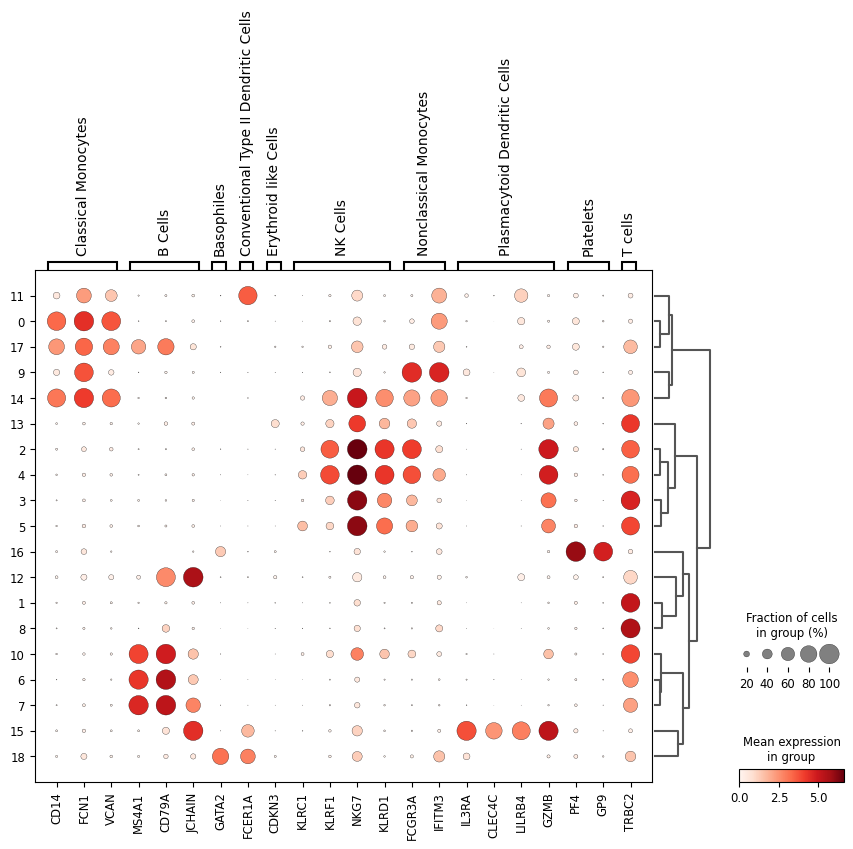

In [194]:

sc.pl.dotplot(adata, marker_gene_dict, groupby = 'leiden', dendrogram=True, save = "ExpressionofMarkerGenesperCluster.png")

categories: 0, 1, 2, etc.
var_group_labels: Classical Monocytes, B Cells, Basophiles, etc.


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:324: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _color_df = _matrix.groupby(level=0).median()
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:405: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pd.DataFrame(_matrix.stack(dropna=False))
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assig

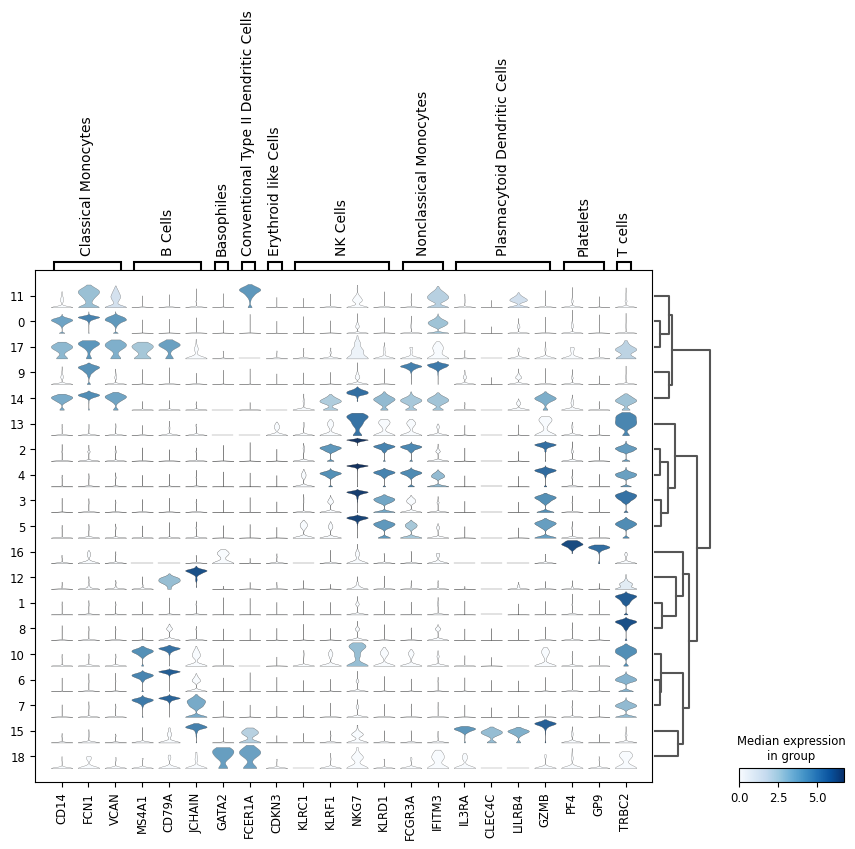

In [195]:
vplot = sc.pl.stacked_violin(adata, marker_gene_dict, groupby='leiden', swap_axes=False, dendrogram=True, save = 'ExpressionofMarkerGenesperCluster.png')

In [107]:
#define the condition 
def map_condition(x):
    if 'NDR' in x: 
        return 'NDR'
    else:
        return 'DR'

In [108]:
adata.obs['condition'] = adata.obs['sample'].map(map_condition) #add condition column 
adata.obs

sample  _scvi_batch  _scvi_labels  doublet  n_genes  \
AAACCCAGTCGAACGA-1   NDR1            0             0    False      251   
AAACCCAGTGACGCCT-1   NDR1            0             0    False      233   
AAACCCAGTGGCCTCA-1   NDR1            0             0    False      273   
AAACCCAGTTTGACAC-1   NDR1            0             0    False      245   
AAACGAAAGACTGAGC-1   NDR1            0             0    False      406   
...                   ...          ...           ...      ...      ...   
TTTGGTTCAAATGAAC-1    DR3            0             0    False      402   
TTTGGTTCAAGTCATC-1    DR3            0             0    False      250   
TTTGGTTCACGCTGAC-1    DR3            0             0    False      254   
TTTGGTTTCGTCGCTT-1    DR3            0             0    False      221   
TTTGTTGTCAAAGGTA-1    DR3            0             0    False      283   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAGTCGAACGA-1                251         825.0              0.0   
AAACCCAGTGACGCCT-1                233         547.0              0.0   
AAACCCAGTGGCCTCA-1                273         832.0              0.0   
AAACCCAGTTTGACAC-1                245         649.0              0.0   
AAACGAAAGACTGAGC-1                406        1115.0              0.0   
...                               ...           ...              ...   
TTTGGTTCAAATGAAC-1                402        3198.0              0.0   
TTTGGTTCAAGTCATC-1                250         827.0              0.0   
TTTGGTTCACGCTGAC-1                254         617.0              0.0   
TTTGGTTTCGTCGCTT-1                221         788.0              0.0   
TTTGTTGTCAAAGGTA-1                283        1106.0              0.0   

                    pct_counts_mt leiden  _scvi_raw_norm_scaling  \
AAACCCAGTCGAACGA-1            0.0      2               14.471780   
AAACCCAGTGACGCCT-1            0.0      2               23.584906   
AAACCCAGTGGCCTCA-1            0.0      0               14.430015   
AAACCCAGTTTGACAC-1            0.0      2               18.656715   
AAACGAAAGACTGAGC-1            0.0      0               12.406948   
...                           ...    ...                     ...   
TTTGGTTCAAATGAAC-1            0.0     11                3.672420   
TTTGGTTCAAGTCATC-1            0.0      0               13.736264   
TTTGGTTCACGCTGAC-1            0.0      0               22.421526   
TTTGGTTTCGTCGCTT-1            0.0      3               17.361111   
TTTGTTGTCAAAGGTA-1            0.0      0               10.152285   

                                               cell_type condition  \
AAACCCAGTCGAACGA-1                              NK Cells       NDR   
AAACCCAGTGACGCCT-1                              NK Cells       NDR   
AAACCCAGTGGCCTCA-1                   Classical Monocytes       NDR   
AAACCCAGTTTGACAC-1                              NK Cells       NDR   
AAACGAAAGACTGAGC-1                   Classical Monocytes       NDR   
...                                                  ...       ...   
TTTGGTTCAAATGAAC-1  Conventional Type II Dendritic Cells        DR   
TTTGGTTCAAGTCATC-1                   Classical Monocytes        DR   
TTTGGTTCACGCTGAC-1                   Classical Monocytes        DR   
TTTGGTTTCGTCGCTT-1                              NK Cells        DR   
TTTGTTGTCAAAGGTA-1                   Classical Monocytes        DR   

                                         celltype_condition  
AAACCCAGTCGAACGA-1                             NK cells_NDR  
AAACCCAGTGACGCCT-1                             NK cells_NDR  
AAACCCAGTGGCCTCA-1                  Classical Monocytes_NDR  
AAACCCAGTTTGACAC-1                             NK cells_NDR  
AAACGAAAGACTGAGC-1                  Classical Monocytes_NDR  
...                                                     ...  
TTTGGTTCAAATGAAC-1  Conventional Type II dendritic cells_DR  
TTTGGTTCAAGTCATC-1                   Classical Monocytes_DR  
TTTGGTTCACGCTGAC-1                   Classical Mo

In [109]:
#counnting total number per sample and saving as dictionary
num_tot_cells = adata.obs.groupby(['sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

/var/folders/d3/b2xsqq0d2d7bzbym5crwvcjm0000gp/T/ipykernel_73843/3092124018.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata.obs.groupby(['sample']).count()


{'DR1': 3995,
 'DR2': 4461,
 'DR3': 5616,
 'NDR1': 5854,
 'NDR2': 2997,
 'NDR3': 4211}

Barplot of Number of Cells per Sample

/var/folders/d3/b2xsqq0d2d7bzbym5crwvcjm0000gp/T/ipykernel_73843/3559351581.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x=keys, y=vals, palette="Blues_d").set_title("Number of Cells in Sample")


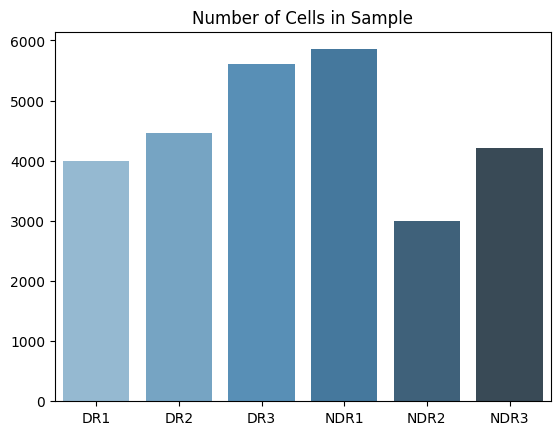

In [187]:
keys = list(num_tot_cells.keys())
vals = list(num_tot_cells.values())
plot = sns.barplot(x=keys, y=vals, palette="Blues_d").set_title("Number of Cells in Sample")
figure = plot.get_figure()
figure.savefig('Barplot of Number of Cells per Sample.png')

In [111]:
adata.obs

sample  _scvi_batch  _scvi_labels  doublet  n_genes  \
AAACCCAGTCGAACGA-1   NDR1            0             0    False      251   
AAACCCAGTGACGCCT-1   NDR1            0             0    False      233   
AAACCCAGTGGCCTCA-1   NDR1            0             0    False      273   
AAACCCAGTTTGACAC-1   NDR1            0             0    False      245   
AAACGAAAGACTGAGC-1   NDR1            0             0    False      406   
...                   ...          ...           ...      ...      ...   
TTTGGTTCAAATGAAC-1    DR3            0             0    False      402   
TTTGGTTCAAGTCATC-1    DR3            0             0    False      250   
TTTGGTTCACGCTGAC-1    DR3            0             0    False      254   
TTTGGTTTCGTCGCTT-1    DR3            0             0    False      221   
TTTGTTGTCAAAGGTA-1    DR3            0             0    False      283   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAGTCGAACGA-1                251         825.0              0.0   
AAACCCAGTGACGCCT-1                233         547.0              0.0   
AAACCCAGTGGCCTCA-1                273         832.0              0.0   
AAACCCAGTTTGACAC-1                245         649.0              0.0   
AAACGAAAGACTGAGC-1                406        1115.0              0.0   
...                               ...           ...              ...   
TTTGGTTCAAATGAAC-1                402        3198.0              0.0   
TTTGGTTCAAGTCATC-1                250         827.0              0.0   
TTTGGTTCACGCTGAC-1                254         617.0              0.0   
TTTGGTTTCGTCGCTT-1                221         788.0              0.0   
TTTGTTGTCAAAGGTA-1                283        1106.0              0.0   

                    pct_counts_mt leiden  _scvi_raw_norm_scaling  \
AAACCCAGTCGAACGA-1            0.0      2               14.471780   
AAACCCAGTGACGCCT-1            0.0      2               23.584906   
AAACCCAGTGGCCTCA-1            0.0      0               14.430015   
AAACCCAGTTTGACAC-1            0.0      2               18.656715   
AAACGAAAGACTGAGC-1            0.0      0               12.406948   
...                           ...    ...                     ...   
TTTGGTTCAAATGAAC-1            0.0     11                3.672420   
TTTGGTTCAAGTCATC-1            0.0      0               13.736264   
TTTGGTTCACGCTGAC-1            0.0      0               22.421526   
TTTGGTTTCGTCGCTT-1            0.0      3               17.361111   
TTTGTTGTCAAAGGTA-1            0.0      0               10.152285   

                                               cell_type condition  \
AAACCCAGTCGAACGA-1                              NK Cells       NDR   
AAACCCAGTGACGCCT-1                              NK Cells       NDR   
AAACCCAGTGGCCTCA-1                   Classical Monocytes       NDR   
AAACCCAGTTTGACAC-1                              NK Cells       NDR   
AAACGAAAGACTGAGC-1                   Classical Monocytes       NDR   
...                                                  ...       ...   
TTTGGTTCAAATGAAC-1  Conventional Type II Dendritic Cells        DR   
TTTGGTTCAAGTCATC-1                   Classical Monocytes        DR   
TTTGGTTCACGCTGAC-1                   Classical Monocytes        DR   
TTTGGTTTCGTCGCTT-1                              NK Cells        DR   
TTTGTTGTCAAAGGTA-1                   Classical Monocytes        DR   

                                         celltype_condition  
AAACCCAGTCGAACGA-1                             NK cells_NDR  
AAACCCAGTGACGCCT-1                             NK cells_NDR  
AAACCCAGTGGCCTCA-1                  Classical Monocytes_NDR  
AAACCCAGTTTGACAC-1                             NK cells_NDR  
AAACGAAAGACTGAGC-1                  Classical Monocytes_NDR  
...                                                     ...  
TTTGGTTCAAATGAAC-1  Conventional Type II dendritic cells_DR  
TTTGGTTCAAGTCATC-1                   Classical Monocytes_DR  
TTTGGTTCACGCTGAC-1                   Classical Mo

In [112]:
#plot frequency of cell type in each sample
cell_type_counts = adata.obs.groupby(['sample', 'condition', 'cell_type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis=1)>0].reset_index() #get rid of 0 rows
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:6]]
cell_type_counts

/var/folders/d3/b2xsqq0d2d7bzbym5crwvcjm0000gp/T/ipykernel_73843/3989953377.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata.obs.groupby(['sample', 'condition', 'cell_type']).count()


sample condition                             cell_type  _scvi_batch  \
0     DR1        DR                               B Cells          591   
1     DR1        DR                            Basophiles            3   
2     DR1        DR                   Classical Monocytes          267   
3     DR1        DR  Conventional Type II Dendritic Cells           12   
4     DR1        DR                  Erythroid like Cells           24   
5     DR1        DR                              NK Cells         1149   
6     DR1        DR                Nonclassical Monocytes          119   
7     DR1        DR          Plasmacytoid Dendritic Cells           10   
8     DR1        DR                             Platelets            2   
9     DR1        DR                               T Cells         1818   
10    DR2        DR                               B Cells          844   
11    DR2        DR                            Basophiles            4   
12    DR2        DR                   Classical Monocytes          588   
13    DR2        DR  Conventional Type II Dendritic Cells           18   
14    DR2        DR                  Erythroid like Cells           36   
15    DR2        DR                              NK Cells         1983   
16    DR2        DR                Nonclassical Monocytes          160   
17    DR2        DR          Plasmacytoid Dendritic Cells           10   
18    DR2        DR                             Platelets           18   
19    DR2        DR                               T Cells          800   
20    DR3        DR                               B Cells          183   
21    DR3        DR                            Basophiles           17   
22    DR3        DR                   Classical Monocytes         2789   
23    DR3        DR  Conventional Type II Dendritic Cells          214   
24    DR3        DR                  Erythroid like Cells           24   
25    DR3        DR                              NK Cells         1406   
26    DR3        DR                Nonclassical Monocytes          472   
27    DR3        DR          Plasmacytoid Dendritic Cells           83   
28    DR3        DR                             Platelets           11   
29    DR3        DR                               T Cells          417   
30   NDR1       NDR                               B Cells          498   
31   NDR1       NDR                            Basophiles           12   
32   NDR1       NDR                   Classical Monocytes         2198   
33   NDR1       NDR  Conventional Type II Dendritic Cells           83   
34   NDR1       NDR                  Erythroid like Cells           32   
35   NDR1       NDR                              NK Cells         2241   
36   NDR1       NDR                Nonclassical Monocytes           79   
37   NDR1       NDR          Plasmacytoid Dendritic Cells           11   
38   NDR1       NDR                             Platelets           21   
39   NDR1       NDR                               T Cells          679   
40   NDR2       NDR                               B Cells         1108   
41   NDR2       NDR                            Basophiles           21   
42   NDR2       NDR                   Classical Monocytes          424   
43   NDR2       NDR  Conventional Type II Dendritic Cells           77   
44   NDR2       NDR                  Erythroid like Cells           51   
45   NDR2       NDR                              NK Cells         1052   
46   NDR2       NDR                Nonclassical Monocytes           79   
47   NDR2       NDR          Plasmacytoid Dendritic Cells           28   
48   NDR2       NDR                             Platelets            4   
49   NDR2       NDR                               T Cells          153   
50   NDR3       NDR                               B Cells          533   
51   NDR3       NDR                   Classical Monocytes          107   
52   NDR3       NDR  Conventional Type II Dendritic Cells            1   
53   ND

In [113]:
cell_type_counts['total_cells'] = cell_type_counts['sample'].map(num_tot_cells).astype(int)
cell_type_counts['frequency'] = cell_type_counts['doublet'] / cell_type_counts['total_cells']
cell_type_counts

sample condition                             cell_type  _scvi_batch  \
0     DR1        DR                               B Cells          591   
1     DR1        DR                            Basophiles            3   
2     DR1        DR                   Classical Monocytes          267   
3     DR1        DR  Conventional Type II Dendritic Cells           12   
4     DR1        DR                  Erythroid like Cells           24   
5     DR1        DR                              NK Cells         1149   
6     DR1        DR                Nonclassical Monocytes          119   
7     DR1        DR          Plasmacytoid Dendritic Cells           10   
8     DR1        DR                             Platelets            2   
9     DR1        DR                               T Cells         1818   
10    DR2        DR                               B Cells          844   
11    DR2        DR                            Basophiles            4   
12    DR2        DR                   Classical Monocytes          588   
13    DR2        DR  Conventional Type II Dendritic Cells           18   
14    DR2        DR                  Erythroid like Cells           36   
15    DR2        DR                              NK Cells         1983   
16    DR2        DR                Nonclassical Monocytes          160   
17    DR2        DR          Plasmacytoid Dendritic Cells           10   
18    DR2        DR                             Platelets           18   
19    DR2        DR                               T Cells          800   
20    DR3        DR                               B Cells          183   
21    DR3        DR                            Basophiles           17   
22    DR3        DR                   Classical Monocytes         2789   
23    DR3        DR  Conventional Type II Dendritic Cells          214   
24    DR3        DR                  Erythroid like Cells           24   
25    DR3        DR                              NK Cells         1406   
26    DR3        DR                Nonclassical Monocytes          472   
27    DR3        DR          Plasmacytoid Dendritic Cells           83   
28    DR3        DR                             Platelets           11   
29    DR3        DR                               T Cells          417   
30   NDR1       NDR                               B Cells          498   
31   NDR1       NDR                            Basophiles           12   
32   NDR1       NDR                   Classical Monocytes         2198   
33   NDR1       NDR  Conventional Type II Dendritic Cells           83   
34   NDR1       NDR                  Erythroid like Cells           32   
35   NDR1       NDR                              NK Cells         2241   
36   NDR1       NDR                Nonclassical Monocytes           79   
37   NDR1       NDR          Plasmacytoid Dendritic Cells           11   
38   NDR1       NDR                             Platelets           21   
39   NDR1       NDR                               T Cells          679   
40   NDR2       NDR                               B Cells         1108   
41   NDR2       NDR                            Basophiles           21   
42   NDR2       NDR                   Classical Monocytes          424   
43   NDR2       NDR  Conventional Type II Dendritic Cells           77   
44   NDR2       NDR                  Erythroid like Cells           51   
45   NDR2       NDR                              NK Cells         1052   
46   NDR2       NDR                Nonclassical Monocytes           79   
47   NDR2       NDR          Plasmacytoid Dendritic Cells           28   
48   NDR2       NDR                             Platelets            4   
49   NDR2       NDR                               T Cells          153   
50   NDR3       NDR                               B Cells          533   
51   NDR3       NDR                   Classical Monocytes          107   
52   NDR3       NDR  Conventional Type II Dendritic Cells            1   
53   ND

Barplot of Cell Type Distribution Between Conditions

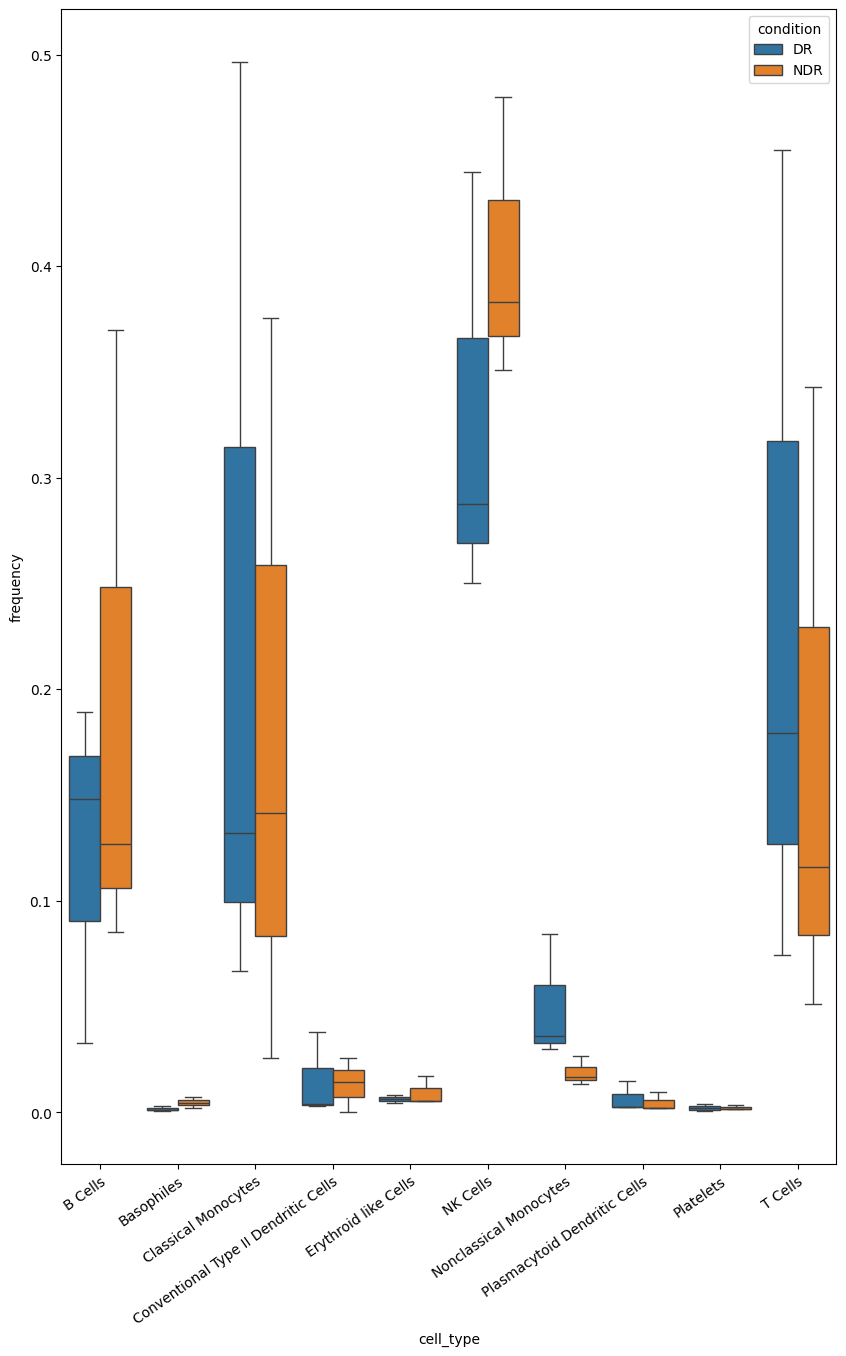

In [193]:
plt.figure(figsize = (10,4))
ax = sns.boxplot(data = cell_type_counts, x = 'cell_type', y = 'frequency', hue = 'condition')
plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')
plt.gcf().set_size_inches(10, 15)
plt.savefig('Barplot of Cell Type Distribution Between Conditions.png', dpi = 200)
plt.show()


# Heatmap of Top Expressed Genes

In [115]:
change_per_cluster_de = model.differential_expression( 
    groupby = "cell_type"
)

DE...: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [116]:
cell_types = (
    adata.obs["cell_type"].value_counts()
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [117]:
marker_genes = (
    change_per_cluster_de.reset_index().loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5])  
    .reset_index(drop=True)["index"]
    .unique()
)

/var/folders/d3/b2xsqq0d2d7bzbym5crwvcjm0000gp/T/ipykernel_73843/2579385621.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  change_per_cluster_de.reset_index().loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]


/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(

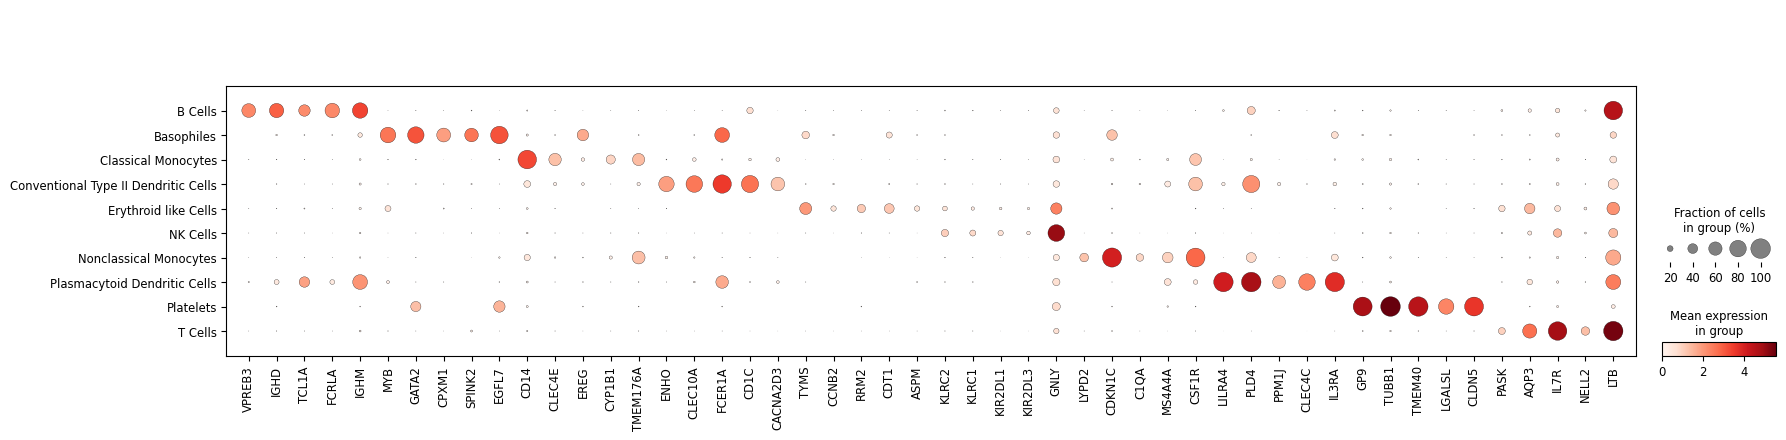

In [182]:
adata_log = adata[adata.obs.cell_type.isin(cell_types.index.values)].copy()
sc.pl.dotplot(adata_log, marker_genes, groupby="cell_type", save = "TopExpressedGenes.png")

# Step 6: Identify Top DE Genes Across Conditions for each Cell Type

In [119]:
adata.obs['celltype_condition'] = adata.obs['cell_type'].str.cat(adata.obs['condition'], sep='_')
adata.obs

sample  _scvi_batch  _scvi_labels  doublet  n_genes  \
AAACCCAGTCGAACGA-1   NDR1            0             0    False      251   
AAACCCAGTGACGCCT-1   NDR1            0             0    False      233   
AAACCCAGTGGCCTCA-1   NDR1            0             0    False      273   
AAACCCAGTTTGACAC-1   NDR1            0             0    False      245   
AAACGAAAGACTGAGC-1   NDR1            0             0    False      406   
...                   ...          ...           ...      ...      ...   
TTTGGTTCAAATGAAC-1    DR3            0             0    False      402   
TTTGGTTCAAGTCATC-1    DR3            0             0    False      250   
TTTGGTTCACGCTGAC-1    DR3            0             0    False      254   
TTTGGTTTCGTCGCTT-1    DR3            0             0    False      221   
TTTGTTGTCAAAGGTA-1    DR3            0             0    False      283   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAGTCGAACGA-1                251         825.0              0.0   
AAACCCAGTGACGCCT-1                233         547.0              0.0   
AAACCCAGTGGCCTCA-1                273         832.0              0.0   
AAACCCAGTTTGACAC-1                245         649.0              0.0   
AAACGAAAGACTGAGC-1                406        1115.0              0.0   
...                               ...           ...              ...   
TTTGGTTCAAATGAAC-1                402        3198.0              0.0   
TTTGGTTCAAGTCATC-1                250         827.0              0.0   
TTTGGTTCACGCTGAC-1                254         617.0              0.0   
TTTGGTTTCGTCGCTT-1                221         788.0              0.0   
TTTGTTGTCAAAGGTA-1                283        1106.0              0.0   

                    pct_counts_mt leiden  _scvi_raw_norm_scaling  \
AAACCCAGTCGAACGA-1            0.0      2               14.471780   
AAACCCAGTGACGCCT-1            0.0      2               23.584906   
AAACCCAGTGGCCTCA-1            0.0      0               14.430015   
AAACCCAGTTTGACAC-1            0.0      2               18.656715   
AAACGAAAGACTGAGC-1            0.0      0               12.406948   
...                           ...    ...                     ...   
TTTGGTTCAAATGAAC-1            0.0     11                3.672420   
TTTGGTTCAAGTCATC-1            0.0      0               13.736264   
TTTGGTTCACGCTGAC-1            0.0      0               22.421526   
TTTGGTTTCGTCGCTT-1            0.0      3               17.361111   
TTTGTTGTCAAAGGTA-1            0.0      0               10.152285   

                                               cell_type condition  \
AAACCCAGTCGAACGA-1                              NK Cells       NDR   
AAACCCAGTGACGCCT-1                              NK Cells       NDR   
AAACCCAGTGGCCTCA-1                   Classical Monocytes       NDR   
AAACCCAGTTTGACAC-1                              NK Cells       NDR   
AAACGAAAGACTGAGC-1                   Classical Monocytes       NDR   
...                                                  ...       ...   
TTTGGTTCAAATGAAC-1  Conventional Type II Dendritic Cells        DR   
TTTGGTTCAAGTCATC-1                   Classical Monocytes        DR   
TTTGGTTCACGCTGAC-1                   Classical Monocytes        DR   
TTTGGTTTCGTCGCTT-1                              NK Cells        DR   
TTTGTTGTCAAAGGTA-1                   Classical Monocytes        DR   

                                         celltype_condition  
AAACCCAGTCGAACGA-1                             NK Cells_NDR  
AAACCCAGTGACGCCT-1                             NK Cells_NDR  
AAACCCAGTGGCCTCA-1                  Classical Monocytes_NDR  
AAACCCAGTTTGACAC-1                             NK Cells_NDR  
AAACGAAAGACTGAGC-1                  Classical Monocytes_NDR  
...                                                     ...  
TTTGGTTCAAATGAAC-1  Conventional Type II Dendritic Cells_DR  
TTTGGTTCAAGTCATC-1                   Classical Monocytes_DR  
TTTGGTTCACGCTGAC-1                   Classical Mo

In [120]:
adata.obs['celltype_condition'].unique()

array(['NK Cells_NDR', 'Classical Monocytes_NDR', 'B Cells_NDR',
       'T Cells_NDR', 'Platelets_NDR',
       'Conventional Type II Dendritic Cells_NDR',
       'Nonclassical Monocytes_NDR', 'Erythroid like Cells_NDR',
       'Plasmacytoid Dendritic Cells_NDR', 'Basophiles_NDR', 'B Cells_DR',
       'T Cells_DR', 'NK Cells_DR', 'Classical Monocytes_DR',
       'Plasmacytoid Dendritic Cells_DR', 'Nonclassical Monocytes_DR',
       'Erythroid like Cells_DR',
       'Conventional Type II Dendritic Cells_DR', 'Platelets_DR',
       'Basophiles_DR'], dtype=object)

# for T-cells

In [121]:
sc.tl.rank_genes_groups(adata, groupby = "celltype_condition", groups = ['T Cells_NDR'], reference = 'T Cells_DR', method = 'wilcoxon', key_added = 'wilcoxon_tcell')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


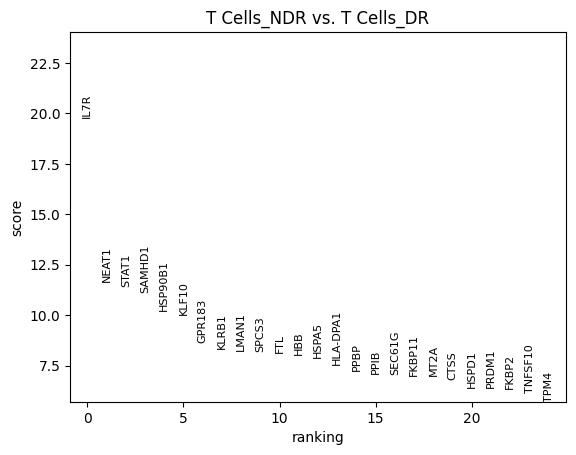

In [122]:
sc.pl.rank_genes_groups(adata, groups = ['T Cells_NDR'], n_genes=25, sharey=False, key="wilcoxon_tcell")

In [168]:
de_tcell = sc.get.rank_genes_groups_df(adata, group = 'T Cells_NDR', key = "wilcoxon_tcell")
de_tcell.iloc[:25].to_csv("tcellsDE.csv")

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


# for B cells 

In [124]:
sc.tl.rank_genes_groups(adata, groupby = "celltype_condition", groups = ['B Cells_NDR'], reference = 'B Cells_DR', method = 'wilcoxon', key_added = 'wilcoxon_bcell')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


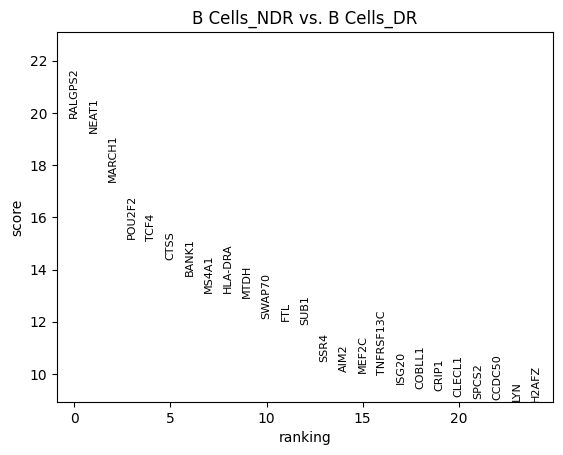

In [125]:
sc.pl.rank_genes_groups(adata, groups = ['B Cells_NDR'], n_genes=25, sharey=False, key="wilcoxon_bcell")

In [167]:
de_bcell = sc.get.rank_genes_groups_df(adata, group = 'B Cells_NDR', key = "wilcoxon_bcell")
de_bcell.iloc[:25].to_csv("bcellsDE.csv")

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


# for Basophiles

In [127]:
sc.tl.rank_genes_groups(adata, groupby = "celltype_condition", groups = ['Basophiles_NDR'], reference = 'Basophiles_DR', method = 'wilcoxon', key_added = 'wilcoxon_baso')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


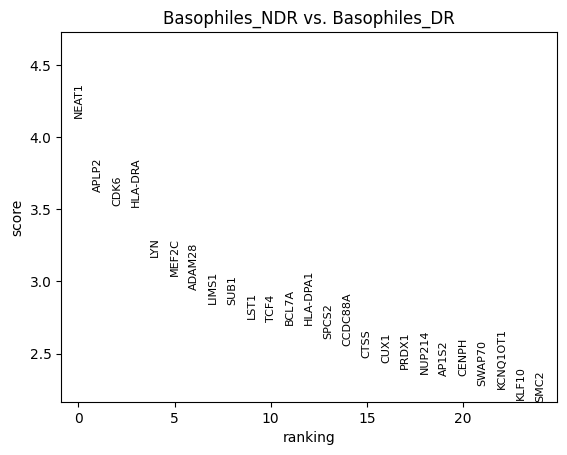

In [128]:
sc.pl.rank_genes_groups(adata, groups = ['Basophiles_NDR'], n_genes=25, sharey=False, key="wilcoxon_baso")

In [166]:
de_baso = sc.get.rank_genes_groups_df(adata, group = 'Basophiles_NDR', key = "wilcoxon_baso")
de_baso.iloc[:25].to_csv("basophilesDE.csv")

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


# for Classical Monocytes

In [130]:
sc.tl.rank_genes_groups(adata, groupby = "celltype_condition", groups = ['Classical Monocytes_NDR'], reference = 'Classical Monocytes_DR', method = 'wilcoxon', key_added = 'wilcoxon_classmon')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


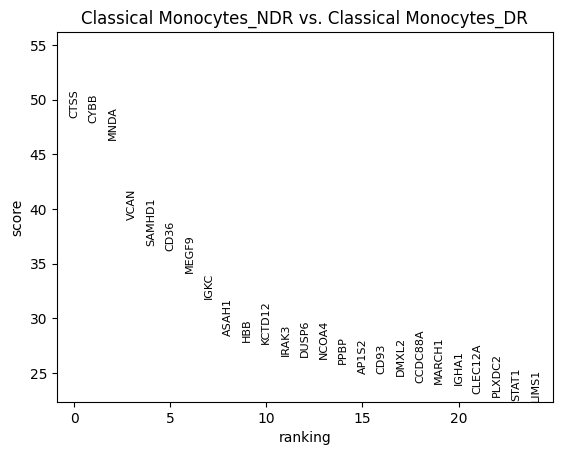

In [131]:
sc.pl.rank_genes_groups(adata, groups = ['Classical Monocytes_NDR'], n_genes=25, sharey=False, key="wilcoxon_classmon")

In [165]:
de_classmon = sc.get.rank_genes_groups_df(adata, group = 'Classical Monocytes_NDR', key = "wilcoxon_classmon")
de_classmon.iloc[:25].to_csv("classicalmonocytesDE.csv")

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


# for Conventional Type II Dendritic Cells 

In [172]:
sc.tl.rank_genes_groups(adata, groupby = "celltype_condition", groups = ['Conventional Type II Dendritic Cells_NDR'], reference = 'Conventional Type II Dendritic Cells_DR', method = 'wilcoxon', key_added = 'wilcoxon_condend')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


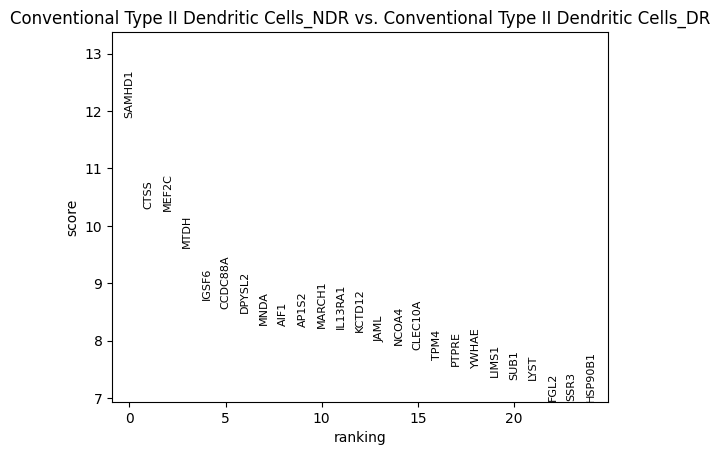

In [173]:
sc.pl.rank_genes_groups(adata, groups = ['Conventional Type II Dendritic Cells_NDR'], n_genes=25, sharey=False, key="wilcoxon_condend")

In [175]:
de_condend = sc.get.rank_genes_groups_df(adata, group = 'Conventional Type II Dendritic Cells_NDR', key = "wilcoxon_condend")
de_condend.iloc[:25].to_csv("conventionaldendriticDE.csv")

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


# for Erythoid like Cells 

In [136]:
sc.tl.rank_genes_groups(adata, groupby = "celltype_condition", groups = ['Erythroid like Cells_NDR'], reference = 'Erythroid like Cells_DR', method = 'wilcoxon', key_added = 'wilcoxon_eryth')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


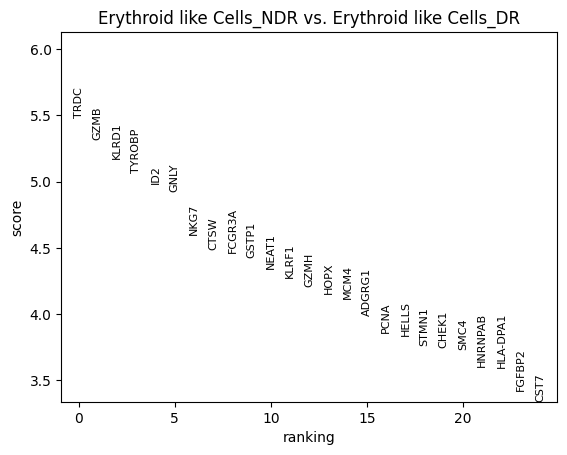

In [137]:
sc.pl.rank_genes_groups(adata, groups = ['Erythroid like Cells_NDR'], n_genes=25, sharey=False, key="wilcoxon_eryth")

In [176]:
de_eryth = sc.get.rank_genes_groups_df(adata, group = 'Erythroid like Cells_NDR', key = "wilcoxon_eryth")
de_eryth.iloc[:25].to_csv("erythroidlikeDE.csv")

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


# for NK cells

In [140]:
sc.tl.rank_genes_groups(adata, groupby = "celltype_condition", groups = ['NK Cells_NDR'], reference = 'NK Cells_DR', method = 'wilcoxon', key_added = 'wilcoxon_nk')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


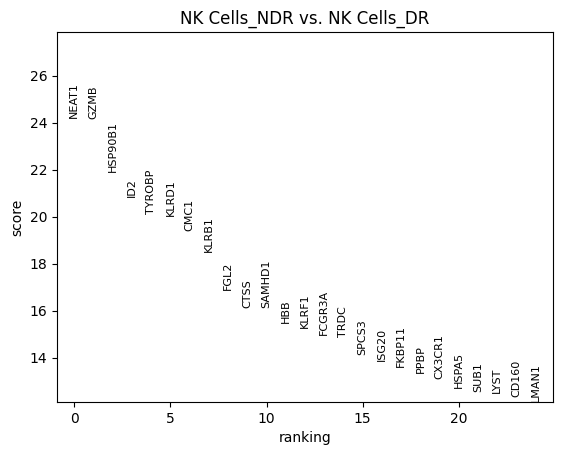

In [141]:
sc.pl.rank_genes_groups(adata, groups = ['NK Cells_NDR'], n_genes=25, sharey=False, key="wilcoxon_nk")

In [177]:
de_nk = sc.get.rank_genes_groups_df(adata, group = 'NK Cells_NDR', key = "wilcoxon_nk")
de_nk.iloc[:25].to_csv("nkDE.csv")

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


# For NonClassical Monocytes

In [143]:
sc.tl.rank_genes_groups(adata, groupby = "celltype_condition", groups = ['Nonclassical Monocytes_NDR'], reference = 'Nonclassical Monocytes_DR', method = 'wilcoxon', key_added = 'wilcoxon_nonmono')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


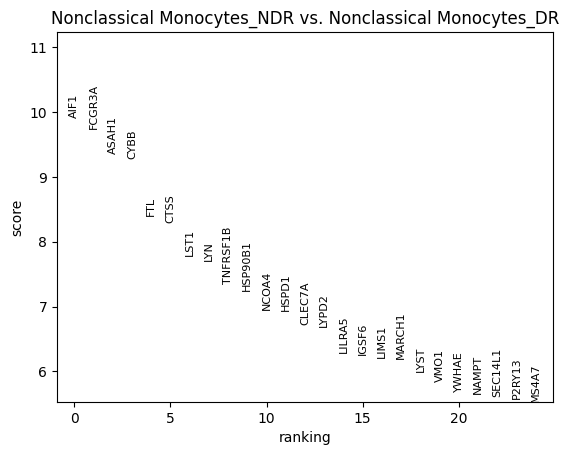

In [144]:
sc.pl.rank_genes_groups(adata, groups = ['Nonclassical Monocytes_NDR'], n_genes=25, sharey=False, key="wilcoxon_nonmono")

In [178]:
de_nonmono = sc.get.rank_genes_groups_df(adata, group = 'Nonclassical Monocytes_NDR', key = "wilcoxon_nonmono")
de_nonmono.iloc[:25].to_csv("nonclassmonocytesDE.csv")

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


# For Plasmacytoid Dendritic Cells

In [146]:
sc.tl.rank_genes_groups(adata, groupby = "celltype_condition", groups = ['Plasmacytoid Dendritic Cells_NDR'], reference = 'Plasmacytoid Dendritic Cells_DR', method = 'wilcoxon', key_added = 'wilcoxon_plasmadend')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


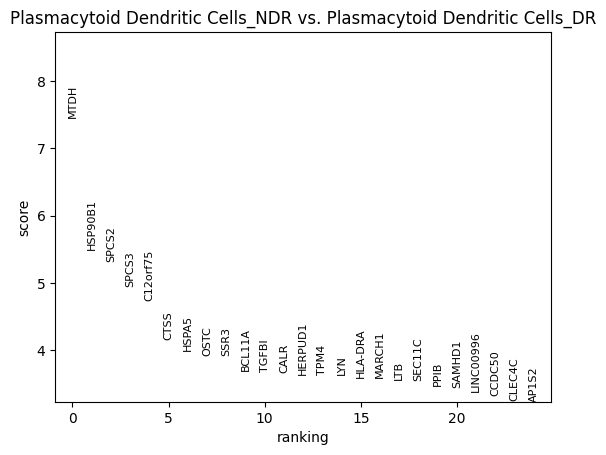

In [147]:
sc.pl.rank_genes_groups(adata, groups = ['Plasmacytoid Dendritic Cells_NDR'], n_genes=25, sharey=False, key="wilcoxon_plasmadend")

In [179]:
de_plasmadend = sc.get.rank_genes_groups_df(adata, group = 'Plasmacytoid Dendritic Cells_NDR', key = "wilcoxon_plasmadend")
de_plasmadend.iloc[:25].to_csv("plasmacytoiddendDE.csv")

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


# For Platelets

In [149]:
sc.tl.rank_genes_groups(adata, groupby = "celltype_condition", groups = ['Platelets_NDR'], reference = 'Platelets_DR', method = 'wilcoxon', key_added = 'wilcoxon_platelet')

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


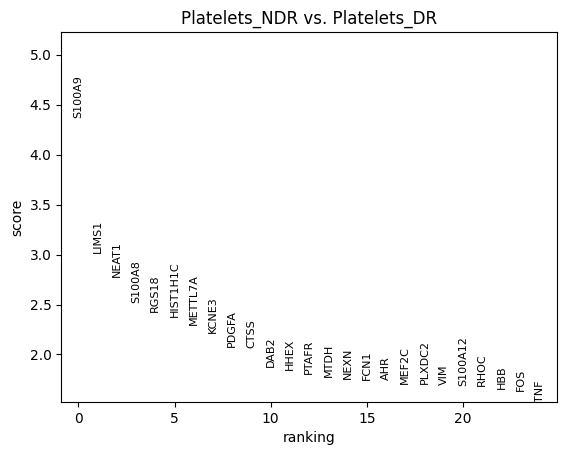

In [150]:
sc.pl.rank_genes_groups(adata, groups = ['Platelets_NDR'], n_genes=25, sharey=False, key="wilcoxon_platelet")

In [180]:
de_platelet = sc.get.rank_genes_groups_df(adata, group = 'Platelets_NDR', key = "wilcoxon_platelet")
de_platelet.iloc[:25].to_csv("plateletDE.csv")

/Users/Emix/miniconda3/envs/myenv/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
